# EIS sklearn models 

In this notebook:
1. Tests of various `sklearn` regression algorithms on ASR data
1. Single-cluster regression models:
    1. Split each cluster into train and test and perform cross-fold validation on that cluster
    1. Train model on one cluster and try to predict other clusters
1. Feature selection with LASSO
1. Classification models (low, med, high ASR)

In [10]:
#add parent directory to sys.path to allow module imports
#see https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder/11158224#11158224
import sys
sys.path.insert(1,'..')

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
import os
import glob
import ternary
import helpers.fileload as fl
from helpers.calc_chemfeat import perovskite, formula_redfeat, formula_pif
from helpers.pickletools import pickle_dict
from helpers.plotting import quat_slice_scatter, add_colorbar, scatter_slices
from helpers.quaternary_plt import QuaternaryAxes
from helpers.outlier_detect import DataCleaner

import pymatgen as mg
import pypif.pif

from ipywidgets import interact, interact_manual, fixed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [360]:
#cell below disables auto-scrolling subwindow in cell output
#cannot have any other code in the cell (even comments) or it breaks

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
} 

<IPython.core.display.Javascript object>

In [3]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/eis') 
#pifdir = os.path.join(datadir,'pifs')
plotdir = os.path.join(tcodir,'scripts/eis/plots')
pickledir = os.path.join(tcodir,'scripts/pickles')

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

## Load data and remove outliers

In [4]:
data = pd.DataFrame()

src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]
for sample in samples:
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':['dry']})
    fl.get_formula(df,overwrite=True)
    df['sample'] = sample
    df.index = df.index + sample
    data = data.append(df,sort=True)
data = data.loc[data['ASR'] > 0,:]
#get el amts after formula normalization
#note that if B-site is ever deficient, this will cause scale issues
Bsite = ['Co','Fe','Zr','Y'] #for B-site normalization
for idx in data.index:
    formula = data.loc[idx,'formula']
    cd = mg.Composition(formula).get_el_amt_dict()
    Bsum = np.sum([v for (k,v) in cd.items() if k in Bsite])
    for k,v in cd.items():
        #normalize to B-site
        data.loc[idx,k] = v/Bsum

#set nans to zero for Bsite
data.loc[:,Bsite] = data.loc[:,Bsite].fillna(0)

data['log_ASR'] = np.log10(data['ASR'])

<IPython.core.display.Javascript object>


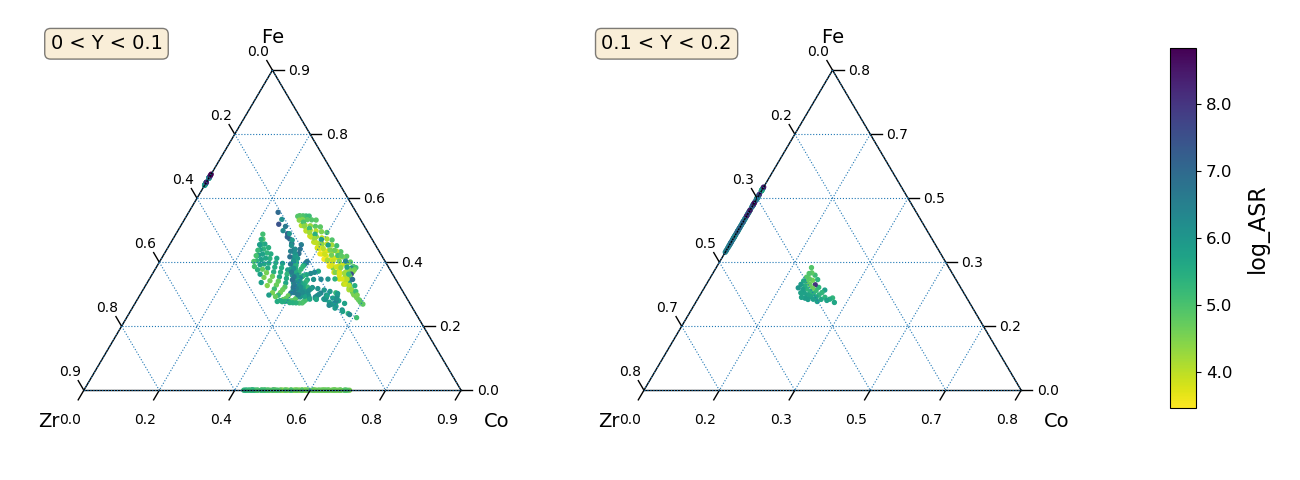

Scale: 0.95
Scale: 0.85


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000194EB4EC978>,
      dtype=object)

In [8]:
%matplotlib notebook
scatter_slices(data,'log_ASR','Y',[0,0.1],0.1,tern_axes=['Co','Fe','Zr'],cmap=plt.cm.viridis_r)

In [12]:
dc = DataCleaner(data,'log_ASR',DB_kw={'eps':0.25},IF_kw={'contamination':0.1})
dc.fit_predict(z_thresh=2)
dc.reduce_comp_dims()

#get cluster number for each sample
np.unique(dc.data_pred['sample'] + ' - ' + dc.data_pred['cluster'].astype(str))

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


['Co', 'Fe', 'Y', 'Zr']


array(['PDAC_COM3_01488 - 0', 'PDAC_COM3_01504 - 1',
       'PDAC_COM3_01533 - 2', 'PDAC_COM3_01535 - 3',
       'PDAC_COM3_01564 - 4'], dtype=object)

<IPython.core.display.Javascript object>


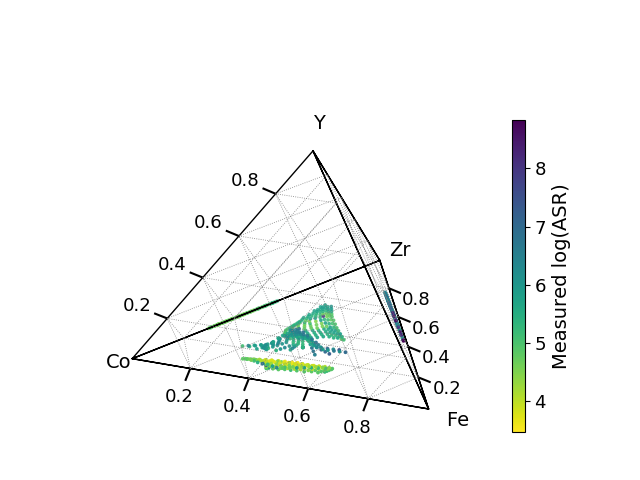

In [62]:
qax = dc.quat_plot(cmap=plt.cm.viridis_r,s=3,cb_label='Measured log(ASR)')
qax.fill()
#plt.savefig(os.path.join(plotdir,'logASR_500C_quat.png'),dpi=500)

<IPython.core.display.Javascript object>


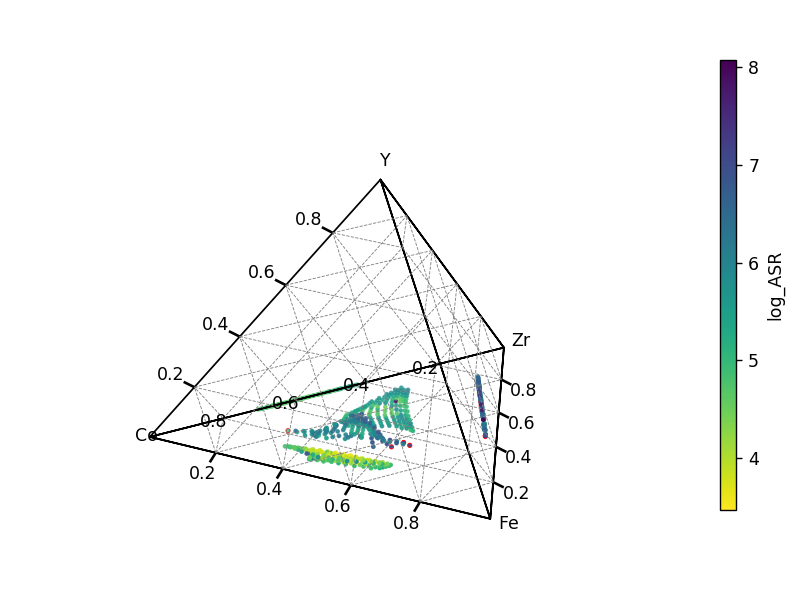

In [45]:
qax1 = dc.quat_highlight(cmap=plt.cm.viridis_r)
qax1.fill()

#plt.savefig(os.path.join(plotdir,'log_ASR_500Cdry_QuatHighlight'), dpi=500)

<IPython.core.display.Javascript object>


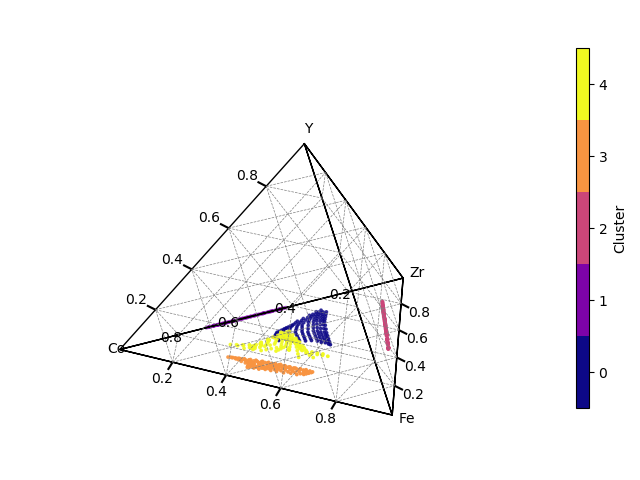

In [37]:
qax2 = dc.quat_clusters()
qax2.fill()
plt.savefig(os.path.join(plotdir,'log_ASR_500Cdry_QuatCluster'), dpi=500)

<IPython.core.display.Javascript object>


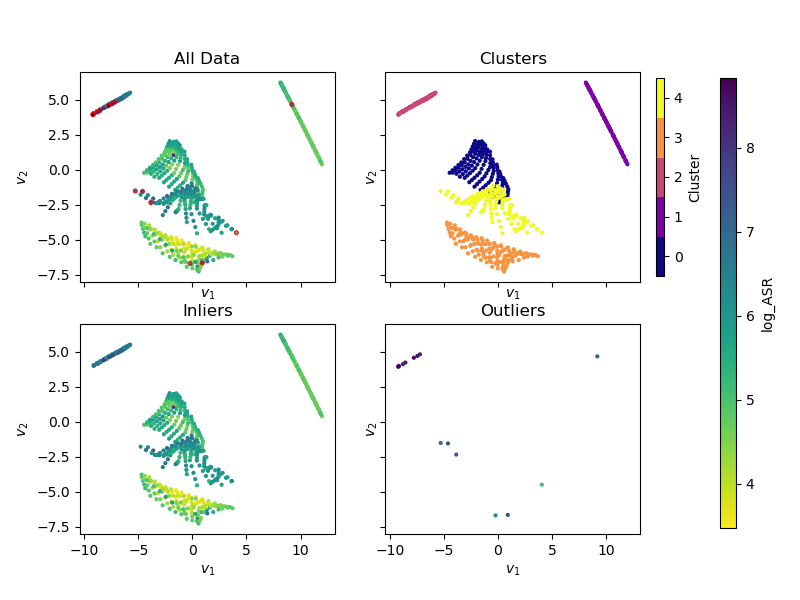

In [78]:
fig, axes = plt.subplots(2,2,figsize=(8,6),sharex=True,sharey=True)
#dc.reduced_plot(cmap=plt.cm.viridis_r,s=4, ax=axes[0,0], cbrect = [0.9,0.12,0.02,0.75])
dc.reduced_highlight_plot(cmap=plt.cm.viridis_r,s=4, ax=axes[0,0], cbrect = [0.9,0.12,0.02,0.75])
dc.reduced_cluster_plot(s=4,ax=axes[0,1],cbrect=[0.82,0.54,0.01,0.33])
dc.reduced_inlier_plot(cmap=plt.cm.viridis_r,s=4,ax=axes[1,0],cbar=False)
dc.reduced_outlier_plot(cmap=plt.cm.viridis_r,s=4,ax=axes[1,1],cbar=False)

#ensure outlier plot has same lims
axes[1,1].set_xlim(axes[0,0].get_xlim())
axes[1,1].set_ylim(axes[0,0].get_ylim())

titles = ['All Data','Clusters','Inliers','Outliers']
for ax, title in zip(axes.ravel(),titles):
    ax.set_title(title)

plt.savefig(os.path.join(plotdir,'logASR_500Cdry_ReducedPlots.png'),dpi=500)

(-6.918973112431615, 7.937921148286257)

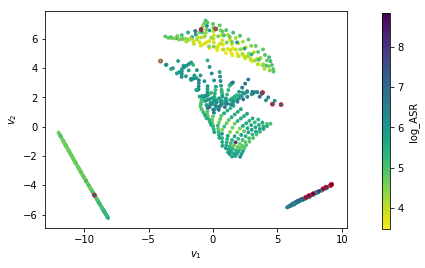

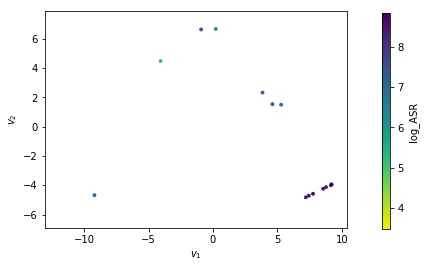

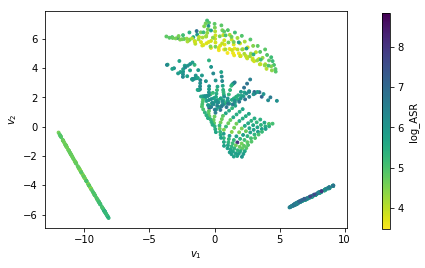

In [6]:
ax = dc.reduced_highlight_plot(cmap=plt.cm.viridis_r)
axo = dc.reduced_outlier_plot(s=8,cmap=plt.cm.viridis_r)
axi = dc.reduced_inlier_plot(s=8,cmap=plt.cm.viridis_r)
axo.set_xlim(ax.get_xlim())
axo.set_ylim(ax.get_ylim())

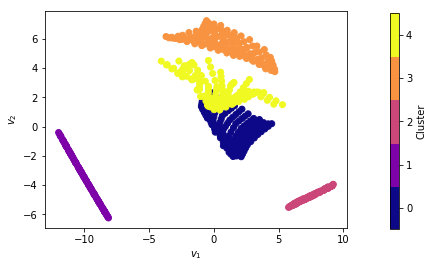

In [7]:
dc.reduced_cluster_plot()

[0 1 2 3 4]
3


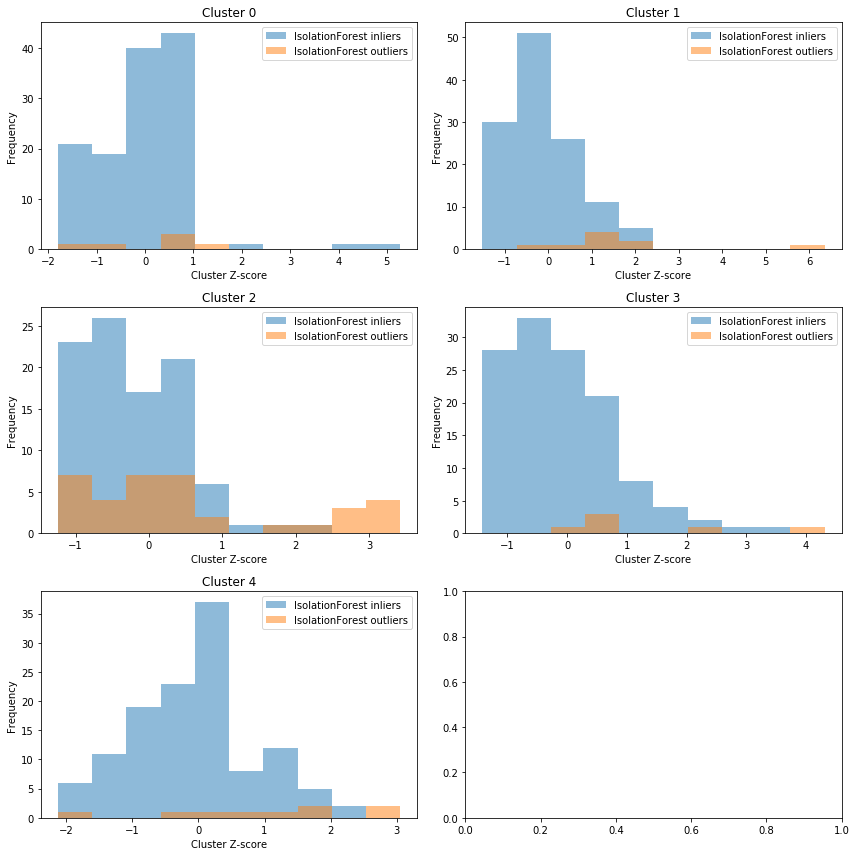

In [8]:
dc.cluster_hist()

In [81]:
dc.remove_outliers()
clean_data = dc.clean_data

# Set up inputs

In [79]:
#load pickles
calc_feat_Co23Fe34 = pickle_dict(os.path.join(pickledir,'feat_Co23Fe34'))
calc_feat_Co24Fe24 = pickle_dict(os.path.join(pickledir,'feat_Co24Fe24'))

In [82]:
input_2334 = pd.DataFrame()
input_2424 = pd.DataFrame()
y = clean_data['log_ASR']
#calculate features
for idx in clean_data.index:
    row = clean_data.loc[idx,:]
    formula = row['formula']
    try:
        f2334 = calc_feat_Co23Fe34.dict[formula]
    except KeyError:
        f2334 = formula_redfeat(formula,cat_ox_lims={'Co':[2,3],'Fe':[3,4]})
        calc_feat_Co23Fe34.dict[formula] = f2334
    try:
        f2424 = calc_feat_Co24Fe24.dict[formula]
    except KeyError:
        f2424 = formula_redfeat(formula,cat_ox_lims={'Co':[2,4],'Fe':[2,4]})
        calc_feat_Co24Fe24.dict[formula] = f2424
        
    f2334['formula'] = formula
    input_2334 = input_2334.append(pd.Series(f2334),ignore_index=True)
    f2424['formula'] = formula
    input_2424 = input_2424.append(pd.Series(f2424),ignore_index=True)

calc_feat_Co23Fe34.update_file()
calc_feat_Co24Fe24.update_file()

Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co23Fe34
Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co24Fe24


# Model testing and selection

In [83]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GroupKFold, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
import collections

In [84]:
def multi_min(arrays):
    mins = []
    for arr in arrays:
        mins.append(min(arr))
    return min(mins)

def multi_max(arrays):
    maxs = []
    for arr in arrays:
        maxs.append(max(arr))
    return max(maxs)

In [85]:
def KFold_cv(X,y,estimator,k=5):
    kf = KFold(k,shuffle=True,random_state=7)
    scores = np.empty(k)
    actual = np.array([])
    pred = np.array([])
    for i, (train_index,test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        estimator.fit(X_train,y_train)
        scores[i] = estimator.score(X_test,y_test)
        actual = np.concatenate((actual,y_test))
        pred = np.concatenate((pred, estimator.predict(X_test)))
    
    return actual, pred, scores
    

def plot_pva(X,y,estimator,ax=None,logscale=False,s=10):
    y_pred = estimator.predict(X)
    if ax is None:
        fig, ax = plt.subplots()
    
    axmin = multi_min([y,y_pred])
    axmax = multi_max([y,y_pred])
    if logscale==False:
        ax.scatter(y,y_pred,s=s)
        ax.plot([axmin,axmax],[axmin,axmax],'g')
    elif logscale==True:
        ax.loglog(y,y_pred,'o',markersize=s)
        ax.loglog([axmin,axmax],[axmin,axmax],'g')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

def KFold_pva(X,y,estimator,k=5,ax=None,logscale=False,s=10):
    y, y_pred, scores = KFold_cv(X,y,estimator,k=k)
    if ax is None:
        fig, ax = plt.subplots()
    axmin = multi_min([y,y_pred])
    axmax = multi_max([y,y_pred])
    if logscale==False:
        ax.scatter(y,y_pred,s=s)
        ax.plot([axmin,axmax],[axmin,axmax],'g')
    elif logscale==True:
        ax.loglog(y,y_pred,'o',markersize=s)
        ax.loglog([axmin,axmax],[axmin,axmax],'g')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    
    return scores
        

In [86]:
def poly_transform(X,powers,inf_val=1e6):

    #each power needs to be applied to each column
    cpowers = np.array(powers*X.shape[1])
    Xr = X.repeat(len(powers),axis=1)

    #matrix to track and retain signs
    Xr_sign = np.sign(Xr)
    #zeros get 0 sign - change to 1
    Xr_sign[Xr_sign==0] = 1
    #elements that will be raised to even powers must be positive after operation - set signs to 1
    power_flag = (cpowers%2!=0).astype(int) #flag for non-even powers in cpowers
    Xr_sign = np.apply_along_axis(lambda x: x**power_flag, 1, Xr_sign) 
        #if even, flag = 0 -> sign becomes 1
        #if not even, flag=1 -> sign unchanged
    

    #feed absolute values in to allow square root of negatives, then reapply signs
    Xt = Xr_sign*(np.abs(Xr)**cpowers)
    Xt[Xt==np.inf] = inf_val
    return Xt


In [87]:
#set up and transform data
drop = ['formula','A_sum','X_a','X_cat_a_oxavg','mass_a','n_a_oxavg','r_a_oxavg']
drop = drop + ['Ba_amt','Co_amt','Fe_amt','Zr_amt','Y_amt'] #remove _amt features - not extensible beyond BCFZY
base_features = input_2334.drop(drop,axis=1).columns.values
X = input_2334.drop(drop,axis=1).values
y = dc.clean_data['log_ASR'].values
clusters = dc.clean_data['sample'].values

#poly transform
powers = [-3,-2,-1,-1/2,1/2,1,2,3]
Xt = poly_transform(X,powers)

#check for infs and nans
np.sum(np.isnan(Xt).astype(int)), np.sum(np.isinf(Xt).astype(int))

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power


(0, 0)

In [88]:
#check which columns have zero or negative values
tmp =  input_2334.drop(drop,axis=1)
zero_cols = set([])
neg_cols = set([])

for idx in tmp.index:
    row = tmp.loc[idx,:]
    zeros = np.where(row.values==0)
    negs = np.where(row.values<0)
    
    for z in zeros[0]:
        zero_cols.add(row.index[z])
    for n in negs[0]:
        neg_cols.add(row.index[n])

zero_cols, neg_cols
    

({'Co:Fe_ratio', 'acceptor_magnitude'}, {'MO_ABE', 'acceptor_magnitude'})

In [112]:
def estimator_test(estimator,X,y,clusters,**params):
    #train separate model for each cluster and compare weights

    unique_clusters = np.unique(clusters)

    train_scores = np.empty(len(unique_clusters))
    test_scores = np.empty(len(unique_clusters))

    #axes for train pva plots
    fig1, axes1 = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)
    #axes for test pva plots
    fig2, axes2 = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)

    ss = StandardScaler()
    X = ss.fit_transform(X) #normalizing results in larger coefficents - less feature variance

    for i, cluster in enumerate(unique_clusters):
        #train a model for each cluster
        cidx = np.where(clusters==cluster)
        #print(cluster,cidx)

        Xc = X[cidx]
        yc = y[cidx]

        lr = estimator(**params)
        lr.fit(Xc,yc)
        train_scores[i] = lr.score(Xc,yc)

        #plot training data
        ax1 = axes1[int(i/3),i%3]
        ax1.set_title(cluster)
        plot_pva(Xc,yc,lr,ax=ax1,logscale=False)

        #plot test data
        ax2 = axes2[int(i/3),i%3]
        ax2.set_title(cluster)
        score = KFold_pva(Xc,yc,lr,k=4,ax=ax2,logscale=False)
        test_scores[i] = np.mean(score)

        #print(lr.intercept_)

    fig1.suptitle('Train',size=14)
    fig2.suptitle('Test',size=14)
    fig1.tight_layout()  
    fig2.tight_layout()
    fig1.subplots_adjust(top=0.88)
    fig2.subplots_adjust(top=0.88)
    axes1[1,2].axis('off')
    axes2[1,2].axis('off')
    print("Train scores: ",train_scores,'\n\tMean: ', np.mean(train_scores))
    print("Test scores: ",test_scores,'\n\tMean: ', np.mean(test_scores))

<IPython.core.display.Javascript object>


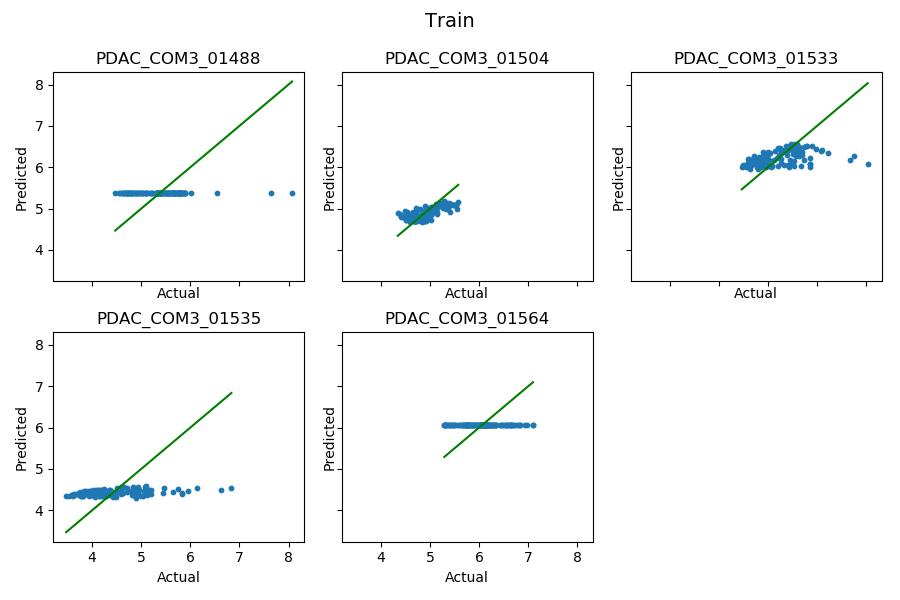

<IPython.core.display.Javascript object>


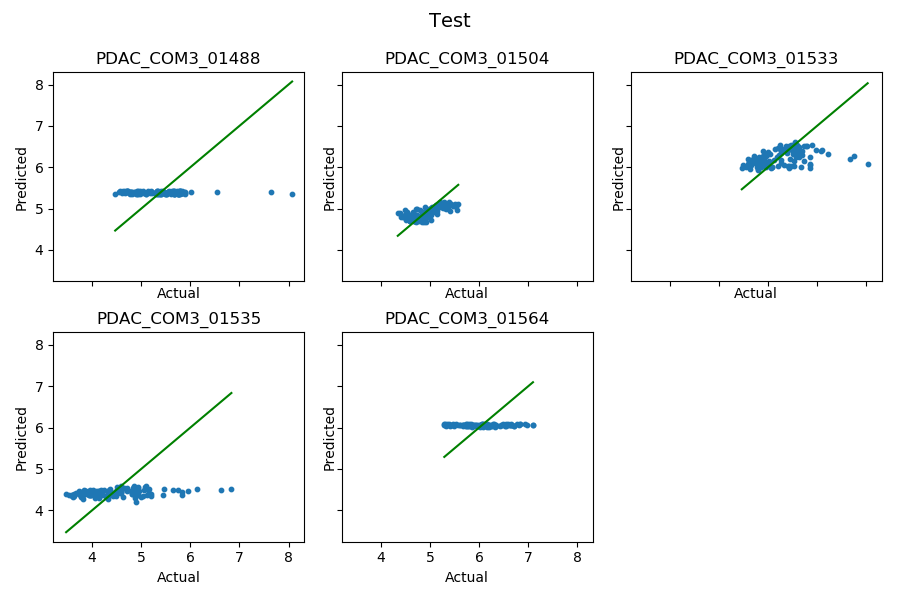

Train scores:  [0.         0.46154937 0.20475554 0.0787473  0.00057486] 
	Mean:  0.14912541552988196
Test scores:  [-0.03161717  0.41788486  0.20710116  0.05259431 -0.01553857] 
	Mean:  0.1260849166883784


In [113]:
estimator_test(ElasticNet,Xt,y,clusters,alpha=0.1)

In [1453]:
X.shape

(645, 24)

In [114]:
#random forest
interact_manual(
    estimator_test,
    estimator = fixed(RandomForestRegressor),
    X=fixed(X),
    y=fixed(y),
    clusters=fixed(clusters),
    n_estimators = [1,2,5,10,25,50],
    max_features = [1,2,3,4,5,10,20,None],
    max_depth = [1,2,5,10,20,None],
    min_samples_leaf = [1, 2, 5, 10, 25, 50],
    min_samples_split = [2, 5, 10, 25, 50, 100],
    criterion = ['mse','mae'],
    bootstrap = [True, False]
        );
#best result (didn't spend too long optimizing):
#n_estimators=25, max_features=5, max_depth=5, min_samples_leaf=5, rest default

interactive(children=(Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='max_features', options=(1, 2, 3, 4, 5, 10, 20, None), value=1), Dropdown(description='max_depth', options=(1, 2, 5, 10, 20, None), value=1), Dropdown(description='min_samples_leaf', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='min_samples_split', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='criterion', options=('mse', 'mae'), value='mse'), Dropdown(description='bootstrap', options=(True, False), value=True), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [107]:
#AdaBoost

interact_manual(
    estimator_test,
    estimator = fixed(AdaBoostRegressor),
    X=fixed(X),
    y=fixed(y),
    clusters=fixed(clusters),
    n_estimators = [1,2,5,10,25,50],
    learning_rate = (0.0,1.5),
    loss = ['linear','square','exponential']
        );

interactive(children=(Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), FloatSlider(value=0.75, description='learning_rate', max=1.5), Dropdown(description='loss', options=('linear', 'square', 'exponential'), value='linear'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [108]:
#gradient boosting
estimator = GradientBoostingRegressor

interact_manual(
    estimator_test,
    estimator = fixed(estimator),
    X=fixed(X),
    y=fixed(y),
    clusters=fixed(clusters),
    loss=['ls','lad','huber','quantile'],
    learning_rate = np.arange(0.05,1.01,0.05),
    n_estimators = [2,5,10,25,50,100],
    subsample = np.arange(0.2,1.01,0.2),
    max_depth = [1,2,3,5,10,20]
    );

interactive(children=(Dropdown(description='loss', options=('ls', 'lad', 'huber', 'quantile'), value='ls'), Dropdown(description='learning_rate', options=(0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.6500000000000001, 0.7000000000000001, 0.7500000000000001, 0.8, 0.8500000000000001, 0.9000000000000001, 0.9500000000000001, 1.0), value=0.05), Dropdown(description='n_estimators', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='subsample', options=(0.2, 0.4, 0.6000000000000001, 0.8, 1.0), value=0.2), Dropdown(description='max_depth', options=(1, 2, 3, 5, 10, 20), value=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [109]:
#elastic net

estimator = ElasticNet

interact_manual(
    estimator_test,
    estimator = fixed(estimator),
    X=fixed(Xt),
    y=fixed(y),
    clusters=fixed(clusters),
    alpha = np.logspace(-4,0,10),
    #from docs: good choice of list of values for l1_ratio is often to put more values close to 1 and less close to 0
    l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    max_iter = [1000,5000,10000],
    selection = ['cyclic','random']
    );

#best test scores
#l1_ratio = 0.0: alpha=0.000774, mean score = 0.31539
#l1_ratio = 0.1: alpha=0.000278, mean score = 0.31384
#l1_ratio = 0.5: alpha=0.0001, mean score = 0.31495
#l1_ratio = 0.9: alpha=0.0001, mean score = 0.31657
#l1_ratio = 0.95: alpha=0.0001, mean score = 0.31665
#l1_ratio = 0.99: alpha=0.0001, mean score = 0.31683
#l1_ratio = 1.0: alpha=0.0001, mean score = 0.31768| without _amts: alpha=0.000278, mean score = 0.30634

interactive(children=(Dropdown(description='alpha', options=(0.0001, 0.0002782559402207126, 0.000774263682681127, 0.002154434690031882, 0.005994842503189409, 0.016681005372000592, 0.046415888336127774, 0.12915496650148828, 0.3593813663804626, 1.0), value=0.0001), Dropdown(description='l1_ratio', options=(0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1), value=0), Dropdown(description='max_iter', options=(1000, 5000, 10000), value=1000), Dropdown(description='selection', options=('cyclic', 'random'), value='cyclic'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

# Elastic net for feature selection

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


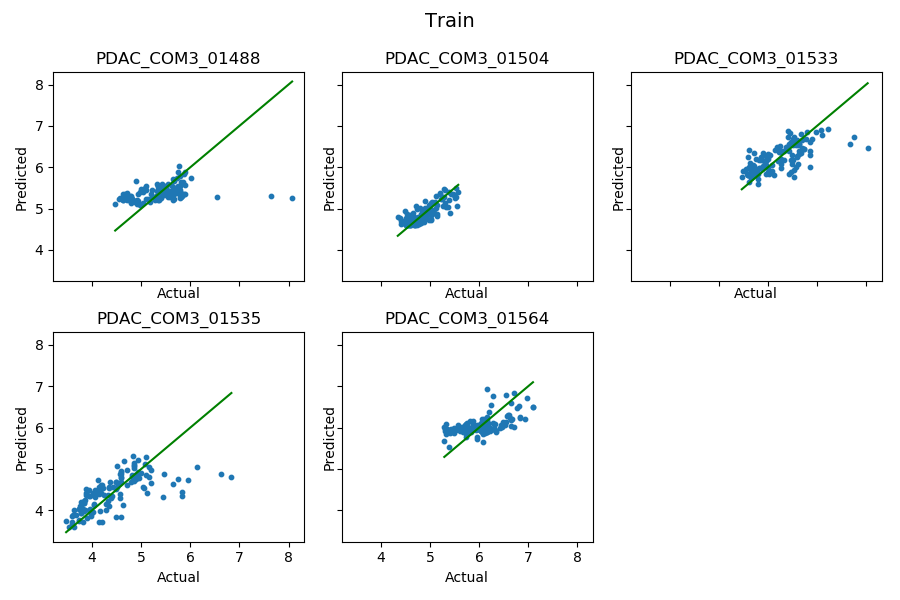

<IPython.core.display.Javascript object>


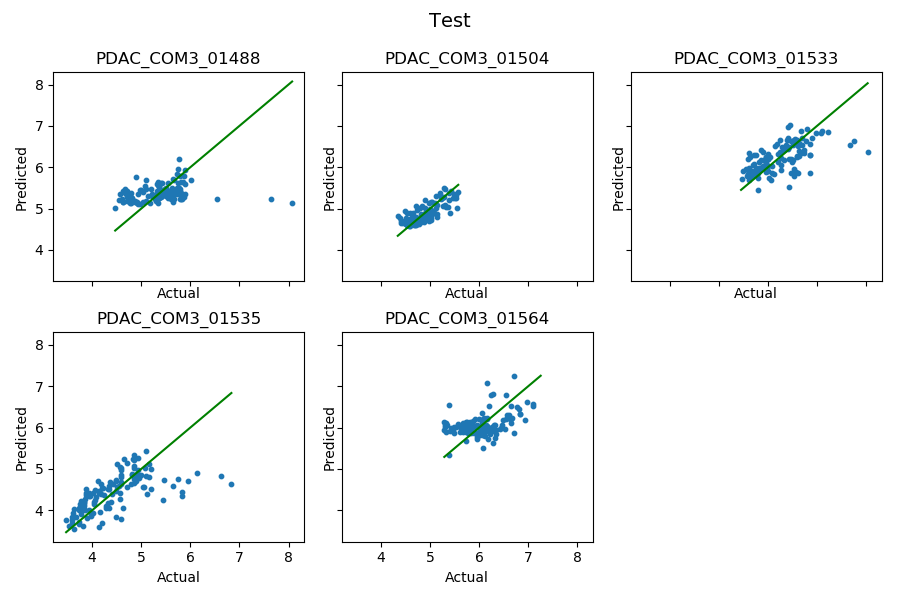

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power
C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


8 non-zero coefficients
Avg non-zero coefficent magnitude: 0.6113572919883185
7 non-zero coefficients
Avg non-zero coefficent magnitude: 0.6693971255478972
15 non-zero coefficients
Avg non-zero coefficent magnitude: 1.1968245677159532
16 non-zero coefficients
Avg non-zero coefficent magnitude: 0.8916591248569183
15 non-zero coefficients
Avg non-zero coefficent magnitude: 0.910061964316087
Train scores:  [0.12631021 0.66814179 0.47440331 0.45745439 0.34686177] 
	Mean:  0.4146342939684411
Test scores:  [0.05709748 0.62509103 0.3455477  0.41533533 0.10050237] 
	Mean:  0.3087147816680023


In [116]:
#train separate model for each cluster and compare weights

#drop unnecessary columns from inputs
drop = ['formula','A_sum','X_a','X_cat_a_oxavg','mass_a','n_a_oxavg','r_a_oxavg']
drop = drop + ['Ba_amt','Co_amt','Fe_amt','Zr_amt','Y_amt']
X = input_2334.drop(drop,axis=1).values
y = dc.clean_data['log_ASR'].values
clusters = dc.clean_data['sample'].values
unique_clusters = np.unique(clusters)

powers = [-3,-2,-1,-1/2,1/2,1,2,3]

train_scores = np.empty(len(unique_clusters))
test_scores = np.empty(len(unique_clusters))
coefs = np.empty((len(unique_clusters),X.shape[1]*len(powers)))


#axes for train pva plots
fig1, axes1 = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)
#axes for test pva plots
fig2, axes2 = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)

ss = StandardScaler()
Xt = poly_transform(X,powers)
Xt = ss.fit_transform(Xt) #normalizing results in larger coefficents - less feature variance

for i, cluster in enumerate(unique_clusters):
    #train a linear model for each cluster
    cidx = np.where(clusters==cluster)
    #print(cluster,cidx)
    
    Xtc = Xt[cidx]
    yc = y[cidx]
    
    #lr = LinearRegression(fit_intercept=True,normalize=False)
    lr = ElasticNet(alpha=0.0003,l1_ratio=1,max_iter=5000)
    #lr = RandomForestRegressor(n_estimators=20,learning_rate=1,loss='linear')
    lr.fit(Xtc,yc)
    train_scores[i] = lr.score(Xtc,yc)
    coefs[i] = lr.coef_
    #print('Avg coef: ',np.mean(np.abs(lr.coef_)))
    print("{} non-zero coefficients".format(len(lr.coef_[lr.coef_ != 0])))
    print("Avg non-zero coefficent magnitude: {}".format(np.mean(np.abs((lr.coef_[lr.coef_ != 0])))))
    
    #plot training data
    ax1 = axes1[int(i/3),i%3]
    ax1.set_title(cluster)
    plot_pva(Xtc,yc,lr,ax=ax1,logscale=False)
    
    #plot test data
    ax2 = axes2[int(i/3),i%3]
    ax2.set_title(cluster)
    score = KFold_pva(Xtc,yc,lr,k=4,ax=ax2,logscale=False)
    test_scores[i] = np.mean(score)
    
    #print(lr.intercept_)

fig1.suptitle('Train',size=14)
fig2.suptitle('Test',size=14)
fig1.tight_layout()  
fig2.tight_layout()
fig1.subplots_adjust(top=0.88)
fig2.subplots_adjust(top=0.88)
axes1[1,2].axis('off')
axes2[1,2].axis('off')

print("Train scores: ",train_scores,'\n\tMean: ', np.mean(train_scores))
print("Test scores: ",test_scores,'\n\tMean: ', np.mean(test_scores))

In [117]:
#identify transformed and base features with non-zero coefficients
nonzeros = []
nonzeros_base = []
for coef in coefs:
    nonzeros.append(np.where(coef!=0))
    #get base variable
    nonzeros_base.append(np.unique((np.where(coef!=0)[0]/len(powers)).astype(int)))
nonzeros, nonzeros_base

([(array([  1,   2,   8,  79,  87, 120, 143, 184], dtype=int64),),
  (array([  0,   6,   7,  24, 160, 168, 176], dtype=int64),),
  (array([  0,   7,   8,  24,  25,  26,  85,  86, 104, 142, 143, 168, 171,
          172, 173], dtype=int64),),
  (array([  0,   8,   9,  10,  11,  12,  13,  14,  15,  24,  72,  78,  79,
          120, 127, 159], dtype=int64),),
  (array([  0,   7,   8,  72,  79,  86,  87, 120, 143, 155, 156, 157, 158,
          159, 169], dtype=int64),)],
 [array([ 0,  1,  9, 10, 15, 17, 23]),
  array([ 0,  3, 20, 21, 22]),
  array([ 0,  1,  3, 10, 13, 17, 21]),
  array([ 0,  1,  3,  9, 15, 19]),
  array([ 0,  1,  9, 10, 15, 17, 19, 21])])

In [118]:
def intersect1d_multi(arrays):
    intersection = arrays[0]
    for arr in arrays[1:]:
        intersection = np.intersect1d(intersection,arr)
        
    return intersection
        
def common_elements(arrays,min_count):
    concat = np.concatenate(arrays)
    counter = dict(collections.Counter(np.concatenate(nonzeros_base)))
    
    return [k for k,v in counter.items() if v>=min_count]
            
#get base features that appear in models for at least 3/5 clusters    
top_features = base_features[common_elements(nonzeros_base,3)]

In [119]:
top_features

array(['A:B_ratio', 'B_sum', 'X_cat_b_oxavg', 'acceptor_magnitude',
       'n_b_oxavg', 'r_b_std_oxavg', 'MO_ABE', 'trans_met_amt'],
      dtype=object)

# build models with top features only

In [120]:
#set up reduced input set using only top base features
X_red = input_2334.loc[:,top_features].values
y = dc.clean_data['log_ASR'].values

#poly transform
powers = [-3,-2,-1,-1/2,1/2,1,2,3]
Xrt = poly_transform(X_red,powers)

#check for infs and nans
np.sum(np.isnan(Xrt).astype(int)), np.sum(np.isinf(Xrt).astype(int))

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power


(0, 0)

In [128]:
#build models using top base features only

estimator = ElasticNet

interact_manual(
    estimator_test,
    estimator = fixed(estimator),
    X=fixed(Xrt),
    y=fixed(y),
    clusters=fixed(clusters),
    alpha = np.logspace(-4,0,10),
    #from docs: good choice of list of values for l1_ratio is often to put more values close to 1 and less close to 0
    l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    max_iter = [1000,5000,10000],
    selection = ['cyclic','random']
    );

#best test scores
#l1_ratio = 0.0: alpha=0.000278, mean score = 0.31303
#l1_ratio = 0.1: alpha=0.000278, mean score = 0.31301
#l1_ratio = 0.5: alpha=0.000278, mean score = 0.30895
#l1_ratio = 0.9: alpha=0.000278, mean score = 0.30541
#l1_ratio = 1.0: alpha=0.000774, mean score = 0.30476

interactive(children=(Dropdown(description='alpha', options=(0.0001, 0.0002782559402207126, 0.000774263682681127, 0.002154434690031882, 0.005994842503189409, 0.016681005372000592, 0.046415888336127774, 0.12915496650148828, 0.3593813663804626, 1.0), value=0.0001), Dropdown(description='l1_ratio', options=(0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1), value=0), Dropdown(description='max_iter', options=(1000, 5000, 10000), value=1000), Dropdown(description='selection', options=('cyclic', 'random'), value='cyclic'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

# test single-cluster models

In [124]:
def cluster_extrap(estimator,X,y,clusters,**params):

    unique_clusters = np.unique(clusters)

    train_scores = np.empty(len(unique_clusters))
    test_scores = np.empty((len(unique_clusters), len(unique_clusters)-1))

    ss = StandardScaler()
    X = ss.fit_transform(X) #normalizing results in larger coefficents - less feature variance

    for i, cluster in enumerate(unique_clusters):
        #train a linear model to one cluster
        cidx = np.where(clusters==cluster)

        Xc = X[cidx]
        yc = y[cidx]

        lr = estimator(**params)
        lr.fit(Xc,yc)
        train_scores[i] = lr.score(Xc,yc)

        #axes for test pva plots
        fig, axes = plt.subplots(2,2,figsize=(6,6),sharex=True,sharey=True)

        #predict other clusters
        for j, oc in enumerate(unique_clusters[unique_clusters != cluster]):
            #oc = other cluster
            ax = axes[int(j/2),j%2]
            ax.set_title(oc)

            #get data for other cluster
            ocidx = np.where(clusters==oc)
            Xoc = X[ocidx]
            yoc = y[ocidx]

            #plot and score
            plot_pva(Xoc,yoc,lr,ax=ax,logscale=False)
            test_scores[i,j] = lr.score(Xoc,yoc)

        fig.suptitle(f'Model trained on {cluster}', size=14)
        fig.tight_layout()
        fig.subplots_adjust(top=0.9)
        print(f"{cluster} train score: ",train_scores[i])
        print(f"{cluster} test scores: ",test_scores[i],'\n\tMean: ', np.mean(test_scores[i]))
        
    print("Mean train score: ",np.mean(train_scores))
    print("Mean test score: ",np.mean(test_scores))

In [125]:
estimator = ElasticNet

interact_manual(
    cluster_extrap,
    estimator = fixed(estimator),
    X=fixed(Xrt),
    y=fixed(y),
    clusters=fixed(clusters),
    alpha = np.logspace(-4,0,10),
    #from docs: good choice of list of values for l1_ratio is often to put more values close to 1 and less close to 0
    l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    max_iter = [1000,5000,10000],
    selection = ['cyclic','random']
    );

interactive(children=(Dropdown(description='alpha', options=(0.0001, 0.0002782559402207126, 0.000774263682681127, 0.002154434690031882, 0.005994842503189409, 0.016681005372000592, 0.046415888336127774, 0.12915496650148828, 0.3593813663804626, 1.0), value=0.0001), Dropdown(description='l1_ratio', options=(0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1), value=0), Dropdown(description='max_iter', options=(1000, 5000, 10000), value=1000), Dropdown(description='selection', options=('cyclic', 'random'), value='cyclic'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [127]:
estimator = RandomForestRegressor

interact_manual(
    cluster_extrap,
    estimator = fixed(estimator),
    X=fixed(X_red),
    y=fixed(y),
    clusters=fixed(clusters),
    n_estimators = [1,2,5,10,25,50],
    max_features = [1,2,3,4,5,10,20,None],
    max_depth = [1,2,5,10,20,None],
    min_samples_leaf = [1, 2, 5, 10, 25, 50],
    min_samples_split = [2, 5, 10, 25, 50, 100],
    criterion = ['mse','mae'],
    bootstrap = [True, False]
    );

#best result:
#n_estimators=10, max_features=2, max_depth=2, min_samples_leaf=1, min_samples_split=2, criterion=mae, bootstrap=True: 
    #mean test score = -6.696

interactive(children=(Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='max_features', options=(1, 2, 3, 4, 5, 10, 20, None), value=1), Dropdown(description='max_depth', options=(1, 2, 5, 10, 20, None), value=1), Dropdown(description='min_samples_leaf', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='min_samples_split', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='criterion', options=('mse', 'mae'), value='mse'), Dropdown(description='bootstrap', options=(True, False), value=True), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [652]:
estimator = AdaBoostRegressor

interact_manual(
    cluster_extrap,
    estimator = fixed(estimator),
    X=fixed(X_red),
    y=fixed(y),
    clusters=fixed(clusters),
    n_estimators = [1,2,5,10,25,50],
    learning_rate = (0.0,1.5),
    loss = ['linear','square','exponential']
    );

#best result:
#n_estimators=2, learning_rate = 0.5, loss=linear
    #mean test score = -6.696

interactive(children=(Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), FloatSlider(value=0.75, description='learning_rate', max=1.5), Dropdown(description='loss', options=('linear', 'square', 'exponential'), value='linear'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [653]:
estimator = GradientBoostingRegressor

interact_manual(
    cluster_extrap,
    estimator = fixed(estimator),
    X=fixed(X_red),
    y=fixed(y),
    clusters=fixed(clusters),
    loss=['ls','lad','huber','quantile'],
    learning_rate = np.arange(0.05,1.01,0.05),
    n_estimators = [2,5,10,25,50,100],
    subsample = np.arange(0.2,1.01,0.2),
    max_depth = [1,2,3,5,10,20]
    );

#best result:
#n_estimators=2, learning_rate = 0.5, loss=linear
    #mean test score = -6.696

interactive(children=(Dropdown(description='loss', options=('ls', 'lad', 'huber', 'quantile'), value='ls'), Dropdown(description='learning_rate', options=(0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.6500000000000001, 0.7000000000000001, 0.7500000000000001, 0.8, 0.8500000000000001, 0.9000000000000001, 0.9500000000000001, 1.0), value=0.05), Dropdown(description='n_estimators', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='subsample', options=(0.2, 0.4, 0.6000000000000001, 0.8, 1.0), value=0.2), Dropdown(description='max_depth', options=(1, 2, 3, 5, 10, 20), value=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

# examine linear coefficients from single-cluster models

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


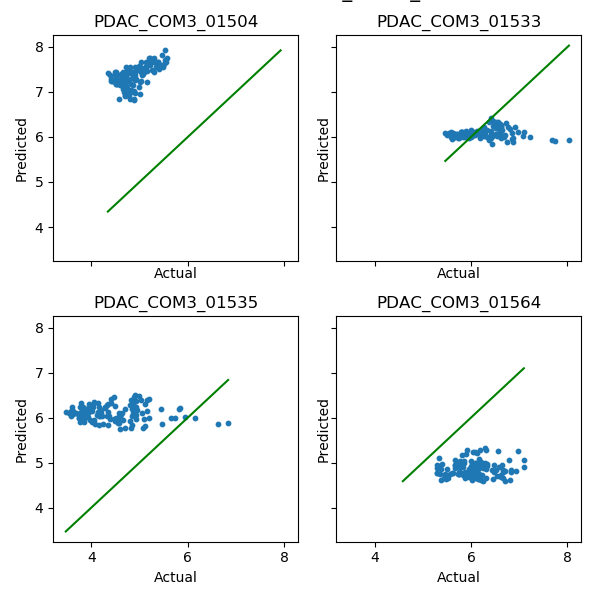

PDAC_COM3_01488 train score:  0.054356809689582675
PDAC_COM3_01488 test scores:  [-70.15034898  -0.08490381  -6.86939368  -8.47374046] 
	Mean:  -21.39459673180364


<IPython.core.display.Javascript object>


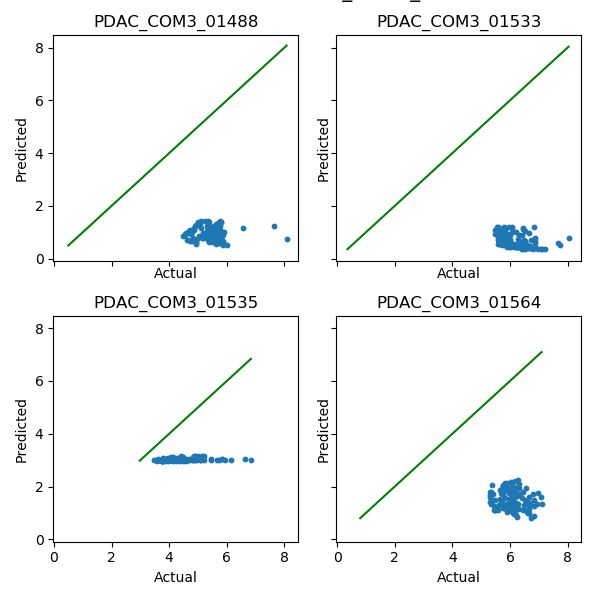

PDAC_COM3_01504 train score:  0.5018693227045093
PDAC_COM3_01504 test scores:  [ -74.70422206 -128.36605617   -4.78072625 -122.72414267] 
	Mean:  -82.64378678959608


<IPython.core.display.Javascript object>


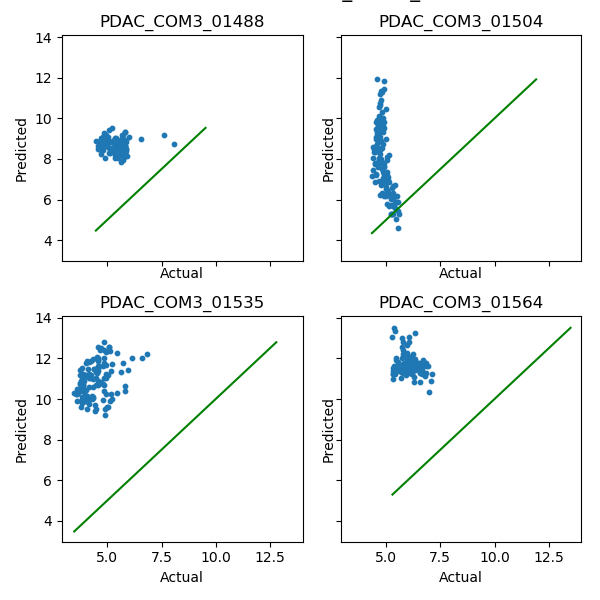

PDAC_COM3_01533 train score:  0.3956149477171028
PDAC_COM3_01533 test scores:  [ -42.1938399  -156.04679025 -104.04685631 -187.83429822] 
	Mean:  -122.53044617007787


<IPython.core.display.Javascript object>


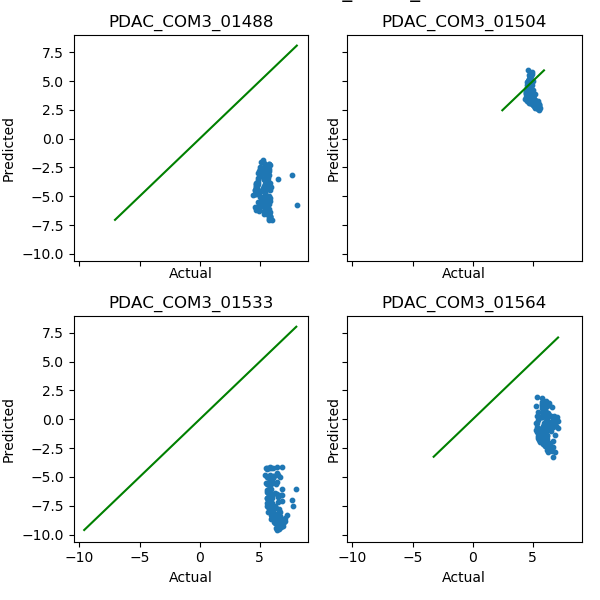

PDAC_COM3_01535 train score:  0.33401995350804803
PDAC_COM3_01535 test scores:  [-378.34385012  -21.11838549 -758.32452995 -268.70576641] 
	Mean:  -356.6231329924958


<IPython.core.display.Javascript object>


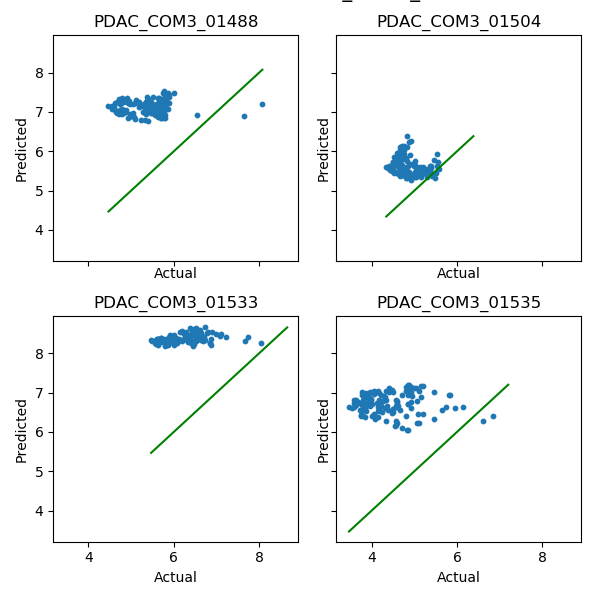

PDAC_COM3_01564 train score:  0.20921927648644822
PDAC_COM3_01564 test scores:  [-11.75381595  -7.40715156 -19.03172915 -12.88712334] 
	Mean:  -12.769955000550004
Mean train score:  0.29901606202113823
Mean test score:  -119.19238353690464


In [129]:
X = X_red
estimator = ElasticNet
params = dict(alpha=0.001,l1_ratio=0.1,max_iter=5000)
# estimator = LinearRegression
# params = {}


unique_clusters = np.unique(clusters)

train_scores = np.empty(len(unique_clusters))
test_scores = np.empty((len(unique_clusters), len(unique_clusters)-1))

coefs = np.empty((len(unique_clusters),X.shape[1] + 1))

ss = StandardScaler()
X = ss.fit_transform(X) #normalizing results in larger coefficents - less feature variance

for i, cluster in enumerate(unique_clusters):
    #train a linear model to one cluster
    cidx = np.where(clusters==cluster)

    Xc = X[cidx]
    yc = y[cidx]

    lr = estimator(**params)
    lr.fit(Xc,yc)
    train_scores[i] = lr.score(Xc,yc)
    coefs[i,0] = lr.intercept_
    coefs[i,1:] = lr.coef_

    #axes for test pva plots
    fig, axes = plt.subplots(2,2,figsize=(6,6),sharex=True,sharey=True)

    #predict other clusters
    for j, oc in enumerate(unique_clusters[unique_clusters != cluster]):
        #oc = other cluster
        ax = axes[int(j/2),j%2]
        ax.set_title(oc)

        #get data for other cluster
        ocidx = np.where(clusters==oc)
        Xoc = X[ocidx]
        yoc = y[ocidx]

        #plot and score
        plot_pva(Xoc,yoc,lr,ax=ax,logscale=False)
        test_scores[i,j] = lr.score(Xoc,yoc)

    fig.suptitle(f'Model trained on {cluster}',y=1.03, size=14)
    fig.tight_layout()
    print(f"{cluster} train score: ",train_scores[i])
    print(f"{cluster} test scores: ",test_scores[i],'\n\tMean: ', np.mean(test_scores[i]))

print("Mean train score: ",np.mean(train_scores))
print("Mean test score: ",np.mean(test_scores))

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


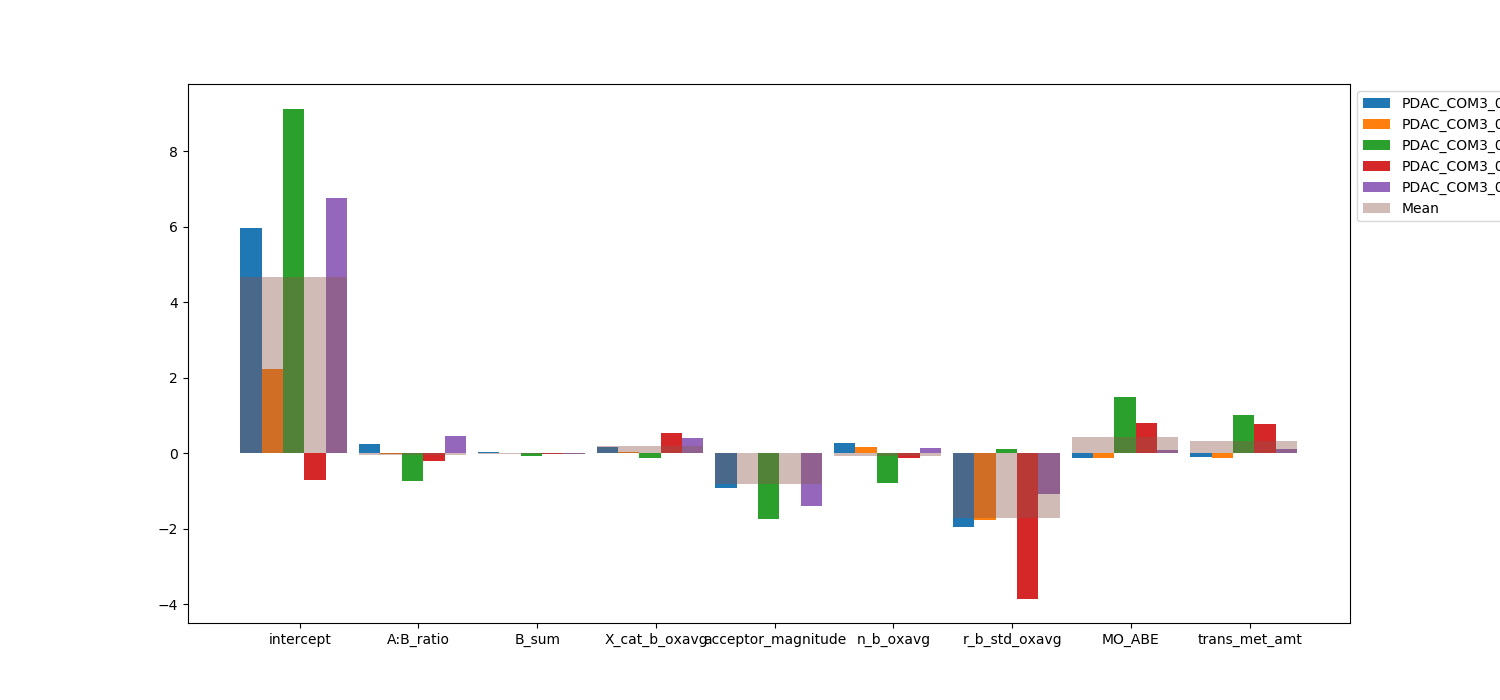

[Text(0,0,'intercept'),
 Text(0,0,'A:B_ratio'),
 Text(0,0,'B_sum'),
 Text(0,0,'X_cat_b_oxavg'),
 Text(0,0,'acceptor_magnitude'),
 Text(0,0,'n_b_oxavg'),
 Text(0,0,'r_b_std_oxavg'),
 Text(0,0,'MO_ABE'),
 Text(0,0,'trans_met_amt')]

In [130]:
fig, ax = plt.subplots(figsize=(15,7))

xs = np.arange(coefs.shape[1])
category_sep = 0.1
bar_sep = 0.0
n_bars = len(unique_clusters)
bar_width = (1 - bar_sep*(n_bars-1) - category_sep)/n_bars
bar_step = bar_width + bar_sep

for i, (cluster,coef) in enumerate(zip(unique_clusters,coefs)):
    ax.bar(x=xs + i*bar_step,height=coef, width=bar_width, label=cluster,align='edge')

mean_coefs = np.mean(coefs,axis=0)
ax.bar(x=xs,height=mean_coefs,width=1-category_sep,label='Mean',align='edge',alpha=0.4)

ax.legend(bbox_to_anchor=(1,1),loc='upper left')
ax.set_xticks(xs+1/2)
ax.set_xticklabels(['intercept'] + list(top_features))


# linear model using average of single-cluster model coefficients

In [604]:
np.mean(coefs,axis=0).shape,len(top_features)

((9,), 8)

In [ ]:
class LinearPredictor():
    def __init__(self,coef,intercept):
        self.coef_ = coef
        self.intercept_ = intercept
        
    def predict(self,X):
        return X@self.coef_ + self.intercept_
    
    def score(self,X,y):
        y_pred = self.predict(X)
        resid = y_pred-y
        var = np.var(y)*len(y)
        return 1 - np.sum(resid**2)/var

Overall score:  -5.5250973093381734
Mean test score:  -19.83031246354443


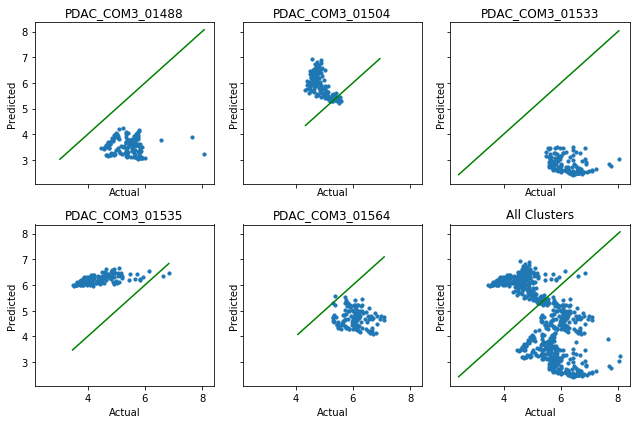

In [614]:
X = X_red
estimator = ElasticNet
params = dict(alpha=0.01,l1_ratio=0.1,max_iter=5000)

mean_coefs = np.mean(coefs,axis=0)
lp = LinearPredictor(mean_coefs[1:],mean_coefs[0])

unique_clusters = np.unique(clusters)

test_scores = np.empty(len(unique_clusters))

ss = StandardScaler()
X = ss.fit_transform(X) #normalizing results in larger coefficents - less feature variance

fig, axes = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)

for i, cluster in enumerate(unique_clusters):
    cidx = np.where(clusters==cluster)

    Xc = X[cidx]
    yc = y[cidx]

    test_scores[i] = lp.score(Xc,yc)
    
    ax = axes[int(i/3),i%3]    
    plot_pva(Xc,yc,lp,ax=ax,logscale=False)
    ax.set_title(cluster)

axt = axes[1,2]
plot_pva(X,y,lp,ax=axt)
axt.set_title('All Clusters')
print('Overall score: ', lp.score(X,y))
    
fig.tight_layout()
print("Mean test score: ",np.mean(test_scores))

# Minimal feature set

Using only those features for which the sign of the coefficient is consistent among the majority of the clusters

In [131]:
min_features = ['acceptor_magnitude','r_b_std_oxavg','X_cat_b_oxavg']

#set up reduced input set using minimal features
X_min = input_2334.loc[:,min_features].values

#poly transform
powers = [-3,-2,-1,-1/2,1/2,1,2,3]
Xmt = poly_transform(X_min,powers)

#check for infs and nans
np.sum(np.isnan(Xmt).astype(int)), np.sum(np.isinf(Xmt).astype(int))

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power


(0, 0)

In [135]:
def cluster_extrap_withcoefs(estimator,X,y,clusters,**params):

    unique_clusters = np.unique(clusters)

    train_scores = np.empty(len(unique_clusters))
    test_scores = np.empty((len(unique_clusters), len(unique_clusters)-1))
    coefs = np.empty((len(unique_clusters),X.shape[1] + 1))
    
    ss = StandardScaler()
    X = ss.fit_transform(X) #normalizing results in larger coefficents - less feature variance

    for i, cluster in enumerate(unique_clusters):
        #train a linear model to one cluster
        cidx = np.where(clusters==cluster)

        Xc = X[cidx]
        yc = y[cidx]

        lr = estimator(**params)
        lr.fit(Xc,yc)
        train_scores[i] = lr.score(Xc,yc)
        coefs[i,0] = lr.intercept_
        coefs[i,1:] = lr.coef_

        #axes for test pva plots
        fig, axes = plt.subplots(2,2,figsize=(6,6),sharex=True,sharey=True)

        #predict other clusters
        for j, oc in enumerate(unique_clusters[unique_clusters != cluster]):
            #oc = other cluster
            ax = axes[int(j/2),j%2]
            ax.set_title(oc)

            #get data for other cluster
            ocidx = np.where(clusters==oc)
            Xoc = X[ocidx]
            yoc = y[ocidx]

            #plot and score
            plot_pva(Xoc,yoc,lr,ax=ax,logscale=False)
            test_scores[i,j] = lr.score(Xoc,yoc)

        fig.suptitle(f'Model trained on {cluster}', size=14)
        fig.tight_layout()
        fig.subplots_adjust(top=0.9)
        print(f"{cluster} train score: ",train_scores[i])
        print(f"{cluster} test scores: ",test_scores[i],'\n\tMean: ', np.mean(test_scores[i]))
        
    print("Mean train score: ",np.mean(train_scores))
    print("Mean test score: ",np.mean(test_scores))
    
    
    fig2, ax2 = plt.subplots(figsize=(12,5))

    xs = np.arange(coefs.shape[1])
    category_sep = 0.1
    bar_sep = 0.0
    n_bars = len(unique_clusters)
    bar_width = (1 - bar_sep*(n_bars-1) - category_sep)/n_bars
    bar_step = bar_width + bar_sep

    for i, (cluster,coef) in enumerate(zip(unique_clusters,coefs)):
        ax2.bar(x=xs + i*bar_step,height=coef, width=bar_width, label=cluster,align='edge')

    mean_coefs = np.mean(coefs,axis=0)
    ax2.bar(x=xs,height=mean_coefs,width=1-category_sep,label='Mean',align='edge',alpha=0.4)

    ax2.legend(bbox_to_anchor=(1,1),loc='upper left')
    ax2.set_xticks(xs+1/2)
    ax2.set_xticklabels(['intercept'] + list(min_features))

In [138]:
estimator = ElasticNet

interact_manual(
    cluster_extrap_withcoefs,
    estimator = fixed(estimator),
    X=fixed(Xmt),
    y=fixed(y),
    clusters=fixed(clusters),
    alpha = np.logspace(-4,0,10),
    #from docs: good choice of list of values for l1_ratio is often to put more values close to 1 and less close to 0
    l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    max_iter = [1000,5000,10000],
    selection = ['cyclic','random']
    );

interactive(children=(Dropdown(description='alpha', options=(0.0001, 0.0002782559402207126, 0.000774263682681127, 0.002154434690031882, 0.005994842503189409, 0.016681005372000592, 0.046415888336127774, 0.12915496650148828, 0.3593813663804626, 1.0), value=0.0001), Dropdown(description='l1_ratio', options=(0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1), value=0), Dropdown(description='max_iter', options=(1000, 5000, 10000), value=1000), Dropdown(description='selection', options=('cyclic', 'random'), value='cyclic'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [133]:
estimator = RandomForestRegressor

interact_manual(
    cluster_extrap,
    estimator = fixed(estimator),
    X=fixed(X_min),
    y=fixed(y),
    clusters=fixed(clusters),
    n_estimators = [1,2,5,10,25,50],
    max_features = [1,2,3,4,5,10,20,None],
    max_depth = [1,2,5,10,20,None],
    min_samples_leaf = [1, 2, 5, 10, 25, 50],
    min_samples_split = [2, 5, 10, 25, 50, 100],
    criterion = ['mse','mae'],
    bootstrap = [True, False]
    );

#best result:
#n_estimators=10, max_features=2, max_depth=2, min_samples_leaf=1, min_samples_split=2, criterion=mae, bootstrap=True: 
    #mean test score = -6.696

interactive(children=(Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='max_features', options=(1, 2, 3, 4, 5, 10, 20, None), value=1), Dropdown(description='max_depth', options=(1, 2, 5, 10, 20, None), value=1), Dropdown(description='min_samples_leaf', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='min_samples_split', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='criterion', options=('mse', 'mae'), value='mse'), Dropdown(description='bootstrap', options=(True, False), value=True), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

# LOCO CV with minimal feature set

In [139]:
def loco_cv(estimator,X,y,clusters):
    if type(X) == pd.core.frame.DataFrame:
        X = X.values
    if type(y) == pd.core.series.Series:
        y = y.values
        
    ss = StandardScaler()
    X = ss.fit_transform(X)
    
    unique_clusters = np.unique(clusters)
    train_scores = np.empty(len(unique_clusters))
    test_scores = np.empty(len(unique_clusters))
    train_act = []
    train_pred = []
    test_act = []
    test_pred = []
    for i, c in enumerate(unique_clusters):
        train_idx = np.where(clusters!=c)
        test_idx = np.where(clusters==c)
        X_train = X[train_idx]
        y_train= y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        estimator.fit(X_train,y_train)
        train_pred.append(estimator.predict(X_train))
        train_act.append(y_train)
        test_pred.append(estimator.predict(X_test))
        test_act.append(y_test)
        train_scores[i] = estimator.score(X_train,y_train)
        test_scores[i] = estimator.score(X_test,y_test)
    
    return train_scores, test_scores, test_pred, test_act, train_pred, train_act

In [140]:
def multi_min(arrays):
    mins = []
    for arr in arrays:
        mins.append(min(arr))
    return min(mins)

def multi_max(arrays):
    maxs = []
    for arr in arrays:
        maxs.append(max(arr))
    return max(maxs)

In [141]:
def estimator_loco_cv(estimator, X,y,clusters, **params):
    
    est = estimator(**params)
    
    train_scores, test_scores, test_pred, test_act, train_pred, train_act = loco_cv(est,X,y,clusters)
    print("Train scores: ", train_scores, "\n\tMean train score: ", np.mean(train_scores))
    print("Test scores: ", test_scores, "\n\tMean test score: ", np.mean(test_scores))
#     fig, ax = plt.subplots()
#     ax.scatter(train_scores, test_scores)
#     ax.scatter(np.mean(train_scores), np.mean(test_scores),marker='d')
#     ax.axhline(0,ls='--')
#     ax.axvline(0,ls='--')
#     ax.set_xlabel('train score')
#     ax.set_ylabel('test score')
    
    #plot train data
    fig1, ax1 = plt.subplots()
    for i, (pred, act) in enumerate(zip(train_pred, train_act)):
        ax1.scatter(act, pred,label=i)
    axmin = multi_min([ax1.get_xlim(),ax1.get_ylim()])
    axmax = multi_max([ax1.get_xlim(),ax1.get_ylim()])
    ax1.plot([axmin,axmax],[axmin,axmax],label='Ideal')
    ax1.legend()
    
    #plot test data
    fig2, axes = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)
    act_means = []
    pred_means = []
    for i, c in enumerate(np.unique(clusters)):
        ax = axes[np.int(i/3),i%3]
        ax.scatter(test_act[i],test_pred[i])
        ax.set_title(c)
        axmin = min(min(test_act[i]),min(test_pred[i]))
        axmax = max(max(test_act[i]),max(test_pred[i]))
        ax.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
        ax.axhline(np.mean(test_act[i]),ls='--',c='k',label='Actual Cluster Mean')
        ax.axhline(np.mean(test_pred[i]),ls='--',c='r',label='Predicted Cluster Mean')
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        #ax.legend()
        fig2.tight_layout()
        
        act_means.append(np.mean(test_act[i]))
        pred_means.append(np.mean(test_pred[i]))
        
    #plot test cluster means
    fig3, ax3 = plt.subplots()
    ax3.scatter(act_means,pred_means)
    ax3.set_xlabel('Actual Cluster Mean')
    ax3.set_ylabel('Predicted Cluster Mean')
    axmin = min(min(act_means),min(pred_means))
    axmax = max(max(act_means),max(pred_means))
    ax3.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
    ax3.legend()
    

In [142]:
estimator = ElasticNet

interact_manual(
    estimator_loco_cv,
    estimator = fixed(estimator),
    X=fixed(Xrt),
    y=fixed(y),
    clusters=fixed(clusters),
    alpha = np.logspace(-4,0,10),
    #from docs: good choice of list of values for l1_ratio is often to put more values close to 1 and less close to 0
    l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    max_iter = [1000,5000,10000],
    selection = ['cyclic','random']
    );
#looks decent with alpha=0.00077, l1_ratio=0.5

interactive(children=(Dropdown(description='alpha', options=(0.0001, 0.0002782559402207126, 0.000774263682681127, 0.002154434690031882, 0.005994842503189409, 0.016681005372000592, 0.046415888336127774, 0.12915496650148828, 0.3593813663804626, 1.0), value=0.0001), Dropdown(description='l1_ratio', options=(0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1), value=0), Dropdown(description='max_iter', options=(1000, 5000, 10000), value=1000), Dropdown(description='selection', options=('cyclic', 'random'), value='cyclic'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [674]:
estimator = RandomForestRegressor

interact_manual(
    estimator_loco_cv,
    estimator = fixed(estimator),
    X=fixed(X_min),
    y=fixed(y),
    clusters=fixed(clusters),
    random_state=fixed(7),
    n_estimators = [1,2,5,10,25,50],
    max_features = [1,2,3,4,5,10,20,None],
    max_depth = [1,2,5,10,20,None],
    min_samples_leaf = [1, 2, 5, 10, 25, 50],
    min_samples_split = [2, 5, 10, 25, 50, 100],
    criterion = ['mse','mae'],
    bootstrap = [True, False]
    );

interactive(children=(Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='max_features', options=(1, 2, 3, 4, 5, 10, 20, None), value=1), Dropdown(description='max_depth', options=(1, 2, 5, 10, 20, None), value=1), Dropdown(description='min_samples_leaf', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='min_samples_split', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='criterion', options=('mse', 'mae'), value='mse'), Dropdown(description='bootstrap', options=(True, False), value=True), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

# Classification

In [143]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sn
from scipy import stats
import time

In [743]:
len(y)

645

In [144]:
"choose cuts for classes"
#cuts = [4.9,5.77,10]

cuts = [np.percentile(y,100/3), np.percentile(y,200/3), np.max(y)]
print(cuts)
cut_means = {}
cut_labels = [-1,0,1]
y_labels = np.empty_like(y)

for i, (cut, cl) in enumerate(zip(cuts,cut_labels)):
    if i==0:
        low = 0
    else:
        low = cuts[i-1]
    high = cut
    cidx = np.where((y>low) & (y<=high))
    y_cut = y[cidx]
    y_labels[cidx] = cl
    num = len(y_cut)
    pct = round(100*num/len(y))
    avg = np.mean(y_cut)
    cut_means[cut] = avg
    
    print(f"{low}-{high}: {num} ({pct}%), mean={avg}")


[4.9141725745368605, 5.784697004986829, 8.072186716225366]
0-4.9141725745368605: 215 (33%), mean=4.448371148258419
4.9141725745368605-5.784697004986829: 215 (33%), mean=5.403940025591316
5.784697004986829-8.072186716225366: 215 (33%), mean=6.293926972421226


In [759]:
np.vstack((y,y_labels)).T

array([[5.22946321, 0.        ],
       [5.33118889, 0.        ],
       [5.75545183, 0.        ],
       ...,
       [6.54656173, 1.        ],
       [6.59696858, 1.        ],
       [6.7122055 , 1.        ]])

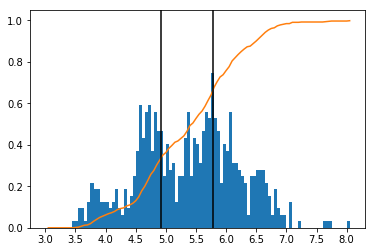

In [749]:
bins = np.arange(3,8.1,0.05)
ticks = np.arange(3,8.1,0.5)
plt.hist(y,bins=bins,density=True)
plt.xticks(ticks)
#plot cumulative pct
hd = np.histogram(y,bins=bins)
plt.plot(bins[1:],np.cumsum(hd[0])/len(y))

#plot cuts
for c in cuts[:-1]:
    plt.axvline(c,c='k')

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


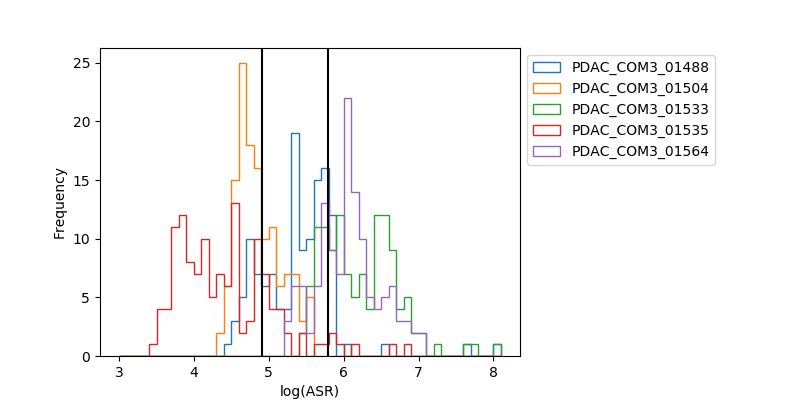

In [150]:
fig, ax = plt.subplots(figsize=(8,4))

for c in unique_clusters:
    cidx = np.where(clusters==c)
    yc = y[cidx]
    ax.hist(yc,bins=np.arange(3,8.11,0.1),label=c,histtype='step')
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('log(ASR)')
ax.set_ylabel('Frequency')
fig.subplots_adjust(right=0.65)

#plot cuts
for c in cuts[:-1]:
    plt.axvline(c,c='k')

In [794]:
idx = np.where(clusters=='PDAC_COM3_01504')
y_labels[idx]

array([-1., -1., -1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1., -1.,
       -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0., -1., -1., -1., -1.,
       -1., -1., -1.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.,
       -1., -1.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1., -1.,  0.,
        0.,  0.,  0., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,
       -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.,  0.,  0., -1., -1., -1., -1.,
       -1., -1., -1., -1.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.,
       -1.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.,  0.,  0.,
        0.,  0.,  0., -1.,  0., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
        0.])

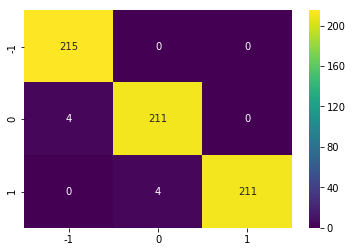

In [819]:
clf = RandomForestClassifier()


clf.fit(X,y_labels)
clf.score(X,y_labels)
y_pred = clf.predict(X)

cm = confusion_matrix(y_labels, y_pred)
df_cm = pd.DataFrame(cm, index=cut_labels,columns=cut_labels)

sn.heatmap(df_cm,annot=True,cmap=plt.cm.viridis,fmt='.0f')

In [796]:
a = np.array([1,2,3])
b = np.array([2,3,4])

np.concatenate((a,b))

array([1, 2, 3, 2, 3, 4])

In [923]:
def clf_loco_cv(clf,X,y,clusters):
    if type(X) == pd.core.frame.DataFrame:
        X = X.values
    if type(y) == pd.core.series.Series:
        y = y.values
        
    ss = StandardScaler()
    X = ss.fit_transform(X)
    
    unique_clusters = np.unique(clusters)
    train_acc = np.empty(len(unique_clusters))
    test_acc = np.empty(len(unique_clusters))
    train_cms = []
    test_cms = []
    
    for i, c in enumerate(unique_clusters):
        train_idx = np.where(clusters!=c)
        test_idx = np.where(clusters==c)
        X_train = X[train_idx]
        y_train= y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        clf.fit(X_train,y_train)
        train_acc[i] = clf.score(X_train,y_train)
        test_acc[i] = clf.score(X_test,y_test)
        #get confusion matrix
        train_pred = clf.predict(X_train)
        test_pred = clf.predict(X_test)
        train_cm = confusion_matrix(y_train,train_pred)
        test_cm = confusion_matrix(y_test,test_pred)
        train_labels = np.unique(np.concatenate((y_train,train_pred)))
        test_labels = np.unique(np.concatenate((y_test,test_pred)))
        train_cm = pd.DataFrame(train_cm,index=train_labels,columns=train_labels)
        test_cm = pd.DataFrame(test_cm,index=test_labels,columns=test_labels)
        train_cms.append(train_cm)
        test_cms.append(test_cm)
    return train_acc, test_acc, train_cms, test_cms

def cm_diff(cm):
    if type(cm) == pd.core.frame.DataFrame:
        cm = cm.values
    
    tot = np.sum(cm)
    diff_dict = {}
    for (i,j), val in np.ndenumerate(cm):
        #i=act, j=pred
        diff = j-i
        try:
            diff_dict[diff] += val/tot
        except KeyError:
            diff_dict[diff] = val/tot
            
    return diff_dict

def cm_score(cm,diff_score={0:1,1:0.5,2:0}):
    diff_dict = cm_diff(cm)
    score = 0
    for key,pct in diff_dict.items():
        ds = diff_score[abs(key)]
        score += pct*ds
        
    return score

def cm_net_err(cm):
    """estimate net direction of prediction error"""
    diff_dict = cm_diff(cm)
    net = 0
    for k,v in diff_dict.items():
        net += k*v
        
    return net

def cm_norm(cm):
    if type(cm) == pd.core.frame.DataFrame:
        cm = cm.values
    
    tot = np.sum(cm)
    normed = cm/tot
    return normed

def plot_clf_loco_cv(classifier, X,y,clusters,cmap,normalize=True, **params):
    
    #unique_labels = np.unique(y)
    unique_clusters = np.unique(clusters)
    
    clf = classifier(**params)
    train_acc, test_acc, train_cms, test_cms = clf_loco_cv(clf,X,y,clusters)
    print("Train accuracy: ", np.round(train_acc,2), "\n\tMean train accuracy: ", round(np.mean(train_acc),4))
    print("Test accuracy: ", np.round(test_acc,2), "\n\tMean test accuracy: ", round(np.mean(test_acc),4))
    
    train_cm_scores = [cm_score(cm) for cm in train_cms]
    test_cm_scores = [cm_score(cm) for cm in test_cms]
    print("Train scores: ", np.round(train_cm_scores,2), "\n\tMean train score: ", round(np.mean(train_cm_scores),4))
    print("Train scores: ", np.round(test_cm_scores,2), "\n\tMean test score: ", round(np.mean(test_cm_scores),4))
    
    train_net_errs = [cm_net_err(cm) for cm in train_cms]
    test_net_errs = [cm_net_err(cm) for cm in test_cms]
    
    print("Test net errors: ", np.round(test_net_errs,2))
    
    
    #axes for test confusion matrices
    fig2, axes2 = plt.subplots(2,3,figsize=(9,6))#,sharex=True,sharey=True)
    #axes for training confusion matrices
    fig1, axes1 = plt.subplots(2,3,figsize=(9,6))
    
    for i, (cluster, train_cm, test_cm) in enumerate(zip(unique_clusters,train_cms, test_cms)):
        ax1 = axes1[np.int(i/3),i%3]
        ax2 = axes2[np.int(i/3),i%3]
        
        if normalize==True:
            train_cm.loc[:,:] = cm_norm(train_cm)
            test_cm.loc[:,:] = cm_norm(test_cm)
            fmt = '.2f'
        else:
            fmt = '.0f'
            
        sn.heatmap(train_cm,annot=True, ax=ax1,fmt=fmt,cmap=cmap)
        sn.heatmap(test_cm,annot=True, ax=ax2,fmt=fmt,cmap=cmap)
        train_net = round(train_net_errs[i],2)
        test_net = round(test_net_errs[i],2)
        train_a = round(train_acc[i],2)
        test_a = round(test_acc[i],2)
        ax1.set_title(f"{cluster}\nAccuracy: {train_a}\nNet Err: {train_net}")
        ax2.set_title(f"{cluster}\nAccuracy: {test_a}\nNet Err: {test_net}")
        for ax in (ax1,ax2):
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            
    fig1.tight_layout()
    fig2.tight_layout()
    fig1.suptitle('Train',size=14,y=1.03)
    fig2.suptitle('Test',size=14,y=1.03)
    axes1[1,2].axis('off')
    axes2[1,2].axis('off')
    


## Test different classifiers

In [927]:
classifier = RandomForestClassifier

#random forest
interact_manual(
    plot_clf_loco_cv,
    classifier = fixed(classifier),
    X=fixed(X_min),
    y=fixed(y_labels),
    clusters=fixed(clusters),
    cmap = fixed(plt.cm.Blues),
    random_state = 7,
    n_estimators = [1,2,5,10,25,50],
    max_features = [1,2,3,4,5,10,20,'auto'],
    max_depth = [1,2,5,10,20,None],
    min_samples_leaf = [1, 2, 5, 10, 25, 50],
    min_samples_split = [2, 5, 10, 25, 50, 100],
    criterion = ['gini','entropy'],
    bootstrap = [True, False]
        );

#best consistent result: n_estimators=5, max_features=2, max_depth=1, min_samples_leaf=1, min_samples_split=2, criterion=gini, bootstrap=False
    #mean accuracy ~ 0.34 across random states

interactive(children=(Checkbox(value=True, description='normalize'), IntSlider(value=7, description='random_state', max=21, min=-7), Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='max_features', options=(1, 2, 3, 4, 5, 10, 20, 'auto'), value=1), Dropdown(description='max_depth', options=(1, 2, 5, 10, 20, None), value=1), Dropdown(description='min_samples_leaf', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='min_samples_split', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='criterion', options=('gini', 'entropy'), value='gini'), Dropdown(description='bootstrap', options=(True, False), value=True), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [1121]:
classifier = SVC

interact_manual(
    plot_clf_loco_cv,
    classifier = fixed(classifier),
    X=fixed(X_min),
    y=fixed(y_labels),
    clusters=fixed(clusters),
    cmap = fixed(plt.cm.Blues),
    C = 1.0,
    kernel =['linear', 'poly', 'rbf', 'sigmoid'],
    degree=3,
    gamma = ['auto',0.01,0.05,0.1,0.25,0.5,1]
        );
#best result: C=1, kernel=poly, degree=5, gamma=0.5; mean accuracy=0.383

interactive(children=(Checkbox(value=True, description='normalize'), FloatSlider(value=1.0, description='C', max=3.0, min=-1.0), Dropdown(description='kernel', options=('linear', 'poly', 'rbf', 'sigmoid'), value='linear'), IntSlider(value=3, description='degree', max=9, min=-3), Dropdown(description='gamma', options=('auto', 0.01, 0.05, 0.1, 0.25, 0.5, 1), value='auto'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [937]:
classifier = AdaBoostClassifier

base1 = DecisionTreeClassifier(max_depth=1,min_samples_leaf=5)
base2 = DecisionTreeClassifier(max_depth=1,min_samples_leaf=10)
base3 = DecisionTreeClassifier(max_depth=10,min_samples_leaf=5)
base4 = DecisionTreeClassifier(max_depth=10,min_samples_leaf=10)
bases = [base1,base2,base3,base4]

interact_manual(
    plot_clf_loco_cv,
    classifier = fixed(classifier),
    X=fixed(X_min),
    y=fixed(y_labels),
    clusters=fixed(clusters),
    cmap = fixed(plt.cm.Blues),
    random_state = 7,
    base_estimator = bases,
    n_estimators = [1,2,5,10,25,50],
    learning_rate = (0.1,1.5)
        );
#best result: C=1, kernel=poly, degree=5, gamma=0.5

interactive(children=(Checkbox(value=True, description='normalize'), IntSlider(value=7, description='random_state', max=21, min=-7), Dropdown(description='base_estimator', options=(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')), value=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')), Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), FloatSlider(value=0.7999999999999999, description='learning_rate', max=1.5, min=0.1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [1283]:
classifier = DecisionTreeClassifier

interact_manual(
    plot_clf_loco_cv,
    classifier = fixed(classifier),
    X=fixed(X_min[:,0].reshape(-1,1)), #(X_min),
    y=fixed(y_labels),
    clusters=fixed(clusters),
    cmap = fixed(plt.cm.Blues),
    random_state = 7,
    splitter = ['best','random'],
    max_depth = [None] + list(np.arange(1,51)),
    min_samples_split = [2,5,10,25,50,100],
    min_samples_leaf = [1,2,5,10,25,50],
    max_features = [None,'auto',1,2,3,4,5],
    criterion = ['gini','entropy']
        );

#best result: spliiter=best, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=auto

interactive(children=(Checkbox(value=True, description='normalize'), IntSlider(value=7, description='random_state', max=21, min=-7), Dropdown(description='splitter', options=('best', 'random'), value='best'), Dropdown(description='max_depth', options=(None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50), value=None), Dropdown(description='min_samples_split', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='min_samples_leaf', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='max_features', options=(None, 'auto', 1, 2, 3, 4, 5), value=None), Dropdown(description='criterion', options=('gini', 'entropy'), value='gini'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## Custom ensemble classifiers

In [1338]:
class SingleFeatureDecisionTree():
    def __init__(self,feature_index,**tree_params):
        self.feature_index = feature_index
        self.clf = DecisionTreeClassifier(**tree_params)
    
    def _get_feature(self,X):
        return X[:,self.feature_index].reshape(-1,1)
    
    def fit(self,X,y):
        Xf = self._get_feature(X)
        self.clf.fit(Xf,y)
    
    def predict(self,X):
        Xf = self._get_feature(X)
        y_pred = self.clf.predict(Xf)
        return y_pred
    
    def score(self,X,y):
        Xf = self._get_feature(X)
        score = self.clf.score(Xf,y)
        return score

class MajorityVotingClassifier():
    def __init__(self,classifiers):
        self.classifiers = classifiers
    
    def fit(self,X,y):
        for clf in self.classifiers:
            clf.fit(X,y)
    
    def predict(self,X):
        pred = np.empty((len(X),len(self.classifiers)))
        for i, clf in enumerate(self.classifiers):
            pred[:,i] = clf.predict(X)
        y_pred = stats.mode(pred,axis=1)[0].flatten()
        return y_pred
    
    def score(self,X,y):
        y_pred = self.predict(X)
        num_correct = np.sum(y_pred==y)
        num = len(y)
        return num_correct/num
    
class DecisionTreeForest():
    def __init__(self,n_trees,**tree_params):
        self.n_trees = n_trees
        self.trees = []
        for i in range(n_trees):
            clf = DecisionTreeClassifier(**tree_params)
            self.trees.append(clf)
    
    def fit(self,X,y):
        for tree in self.trees:
            tree.fit(X,y)
    
    def predict(self,X):
        pred = np.empty((len(X),len(self.trees)))
        for i, tree in enumerate(self.trees):
            pred[:,i] = tree.predict(X)
        y_pred = stats.mode(pred,axis=1)[0].flatten()
        return y_pred
    
    def score(self,X,y):
        y_pred = self.predict(X)
        num_correct = np.sum(y_pred==y)
        num = len(y)
        return num_correct/num

In [1344]:
classifier = MajorityVotingClassifier

estimators = []
for i in range(X_min.shape[1]):
    sf = SingleFeatureDecisionTree(feature_index=i,splitter='best',max_depth=10)
    estimators.append(sf)

interact_manual(
    plot_clf_loco_cv,
    classifier = fixed(classifier),
    X=fixed(X_min), #(X_min),
    y=fixed(y_labels),
    clusters=fixed(clusters),
    cmap = fixed(plt.cm.Blues),
    classifiers = fixed(estimators)
        );

#best result: spliiter=best, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=auto

interactive(children=(Checkbox(value=True, description='normalize'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [1033]:
params = dict(splitter='best',max_depth=10,max_features='auto')
    
classifier = DecisionTreeForest

interact_manual(
    plot_clf_loco_cv,
    classifier = fixed(classifier),
    X = fixed(X_min),
    y = fixed(y_labels),
    clusters = fixed(clusters),
    cmap=fixed(plt.cm.Blues),
    n_trees=[10,15,20,25,50],
    splitter = ['best','random'],
    max_depth = [None] + list(np.arange(1,51)),
    min_samples_split = [2,5,10,25,50,100],
    min_samples_leaf = [1,2,5,10,25,50],
    max_features = ['auto',None,1,2,3,4,5],
    criterion = ['gini','entropy']              
    )
#consistent regularized result: n_trees=20, splitter='best',max_depth=10, min_samples_split=25, min_samples_leaf=10, max_features=None,criterion='gini'

interactive(children=(Checkbox(value=True, description='normalize'), Dropdown(description='n_trees', options=(10, 15, 20, 25, 50), value=10), Dropdown(description='splitter', options=('best', 'random'), value='best'), Dropdown(description='max_depth', options=(None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50), value=None), Dropdown(description='min_samples_split', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='min_samples_leaf', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='max_features', options=('auto', None, 1, 2, 3, 4, 5), value='auto'), Dropdown(description='criterion', options=('gini', 'entropy'), value='gini'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_clf_loco_cv>

In [1023]:
clf = DecisionTreeForest(params,2)
clf.fit(X_min,y_labels)
clf.predict(X_min).shape

(645,)

In [958]:
classifier = BaggingClassifier

defaults = dict(max_features='auto',splitter='best',criterion='gini')

base11 = DecisionTreeClassifier(max_depth=1,min_samples_leaf=1,**defaults)
base15 = DecisionTreeClassifier(max_depth=1,min_samples_leaf=5,**defaults)
base110 = DecisionTreeClassifier(max_depth=1,min_samples_leaf=10,**defaults)
base21 = DecisionTreeClassifier(max_depth=2,min_samples_leaf=1,**defaults)
base210 = DecisionTreeClassifier(max_depth=2,min_samples_leaf=10,**defaults)
base510 = DecisionTreeClassifier(max_depth=5,min_samples_leaf=10,**defaults)
base101 = DecisionTreeClassifier(max_depth=10,min_samples_leaf=1,**defaults)
base105 = DecisionTreeClassifier(max_depth=10,min_samples_leaf=5,**defaults)
base1010 = DecisionTreeClassifier(max_depth=10,min_samples_leaf=10,**defaults)
bases = [base11,
    base15,
    base110, 
    base21,
    base210, 
    base510, 
    base101,
    base105, 
    base1010]

interact_manual(
    plot_clf_loco_cv,
    classifier = fixed(classifier),
    X=fixed(X_min),
    y=fixed(y_labels),
    clusters=fixed(clusters),
    cmap = fixed(plt.cm.Blues),
    random_state = 7,
    base_estimator=bases,
    n_estimators=(1,20),
    max_samples = (0.0,1.0),
    max_features = [3,2,1],
    bootstrap = [False,True]
        );

#consistent result: base_estimator = base110, n_estimators=10, max_samples=1,,max_features=3,bootstrap=False

interactive(children=(Checkbox(value=True, description='normalize'), IntSlider(value=7, description='random_state', max=21, min=-7), Dropdown(description='base_estimator', options=(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')), value=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')), IntSlider(value=10, description='n_estimators', max=20, min=1), FloatSlider(value=0.5, description='max_samples', max=1.0), Dropdown(description='max_features', options=(3, 2, 1), value=3), Dropdown(description='bootstrap', options=(False, True), value=False), Button(description='Run Interact', style=Bu

# Stacked classifier

In [1435]:
#class StackedEstimator()

def loco_base_predict(base_estimators,X,y,clusters, normalize=True):
    """
    Get base estimator predictions using LOCO partitioning
    Predict each cluster using other clusters as training data
    """
    start = time.time()
    if type(X) == pd.core.frame.DataFrame:
        X = X.values
    if type(y) == pd.core.series.Series:
        y = y.values
        
    if normalize==True:
        ss = StandardScaler()
        X = ss.fit_transform(X)
    
    unique_clusters = np.unique(clusters)
#     train_acc = np.empty(len(unique_clusters))
#     test_acc = np.empty(len(unique_clusters))
#     train_cms = []
#     test_cms = []
    
    base_predictions = np.empty((len(X),len(estimators)))
    
    base_estimator_scores = np.zeros(len(base_estimators))
    for i, c in enumerate(unique_clusters):
        train_idx = np.where(clusters!=c)
        test_idx = np.where(clusters==c)
        X_train = X[train_idx]
        y_train= y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        
        for i, est in enumerate(base_estimators.values()):
            est.fit(X_train,y_train)
            base_predictions[test_idx,i] = est.predict(X_test)
            weight = len(y_test)/len(y)
            base_estimator_scores[i] += weight*est.score(X_test,y_test)
    base_names = list(base_estimators.keys())
    base_predictions_df = pd.DataFrame(base_predictions, columns = base_names)
    base_estimator_scores = dict(zip(base_names,np.round(base_estimator_scores,2)))
    
    elapsed = time.time() - start
    print(f"loco_base_predict time: {elapsed}")
    
    return base_predictions_df, base_estimator_scores

def get_base_data_loco(base_estimators,X,y,clusters,cv_cluster,include_orig_features):
    """
    Get training and test data with base estimator predictions
    Base estimator predictions for training data generated by loco_base_predict
    Base estimator predictions for test data generated with models fit to full training dataset
    
    Parameters:
    -----------
    base_estimators: dict of estimators (name:obj)
    
    """   
    train_idx = np.where(clusters!=cv_cluster)
    test_idx = np.where(clusters==cv_cluster)
    X_train = X[train_idx]
    y_train = y[train_idx]
    clusters_train = clusters[train_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    
    #normalize based on X_train
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    #get base predictions on training data
    train_pred_df, train_scores = loco_base_predict(base_estimators,X_train,y_train,clusters_train, normalize=False)
    
    #get base predictions on test data (cv_cluster)
    test_pred = np.empty((len(X_test),len(estimators)))
    test_scores = np.zeros(len(base_estimators))
    for i, (name,est) in enumerate(base_estimators.items()):
        start = time.time()
        est.fit(X_train,y_train)
        test_pred[:,i] = est.predict(X_test)
        test_scores[i] = est.score(X_test,y_test)
        elapsed = time.time() - start
        #print(f'train/predict/score time for estimator {name}: {elapsed}')
    
    base_names = list(base_estimators.keys())
    #test_pred_df = pd.DataFrame(test_pred, columns = base_names)
    test_scores = dict(zip(base_names,np.round(test_scores,2)))
    
    if include_orig_features is True:
        X_train_base = np.hstack((X_train,train_pred_df.values))
        X_test_base = np.hstack((X_test,test_pred))
    elif include_orig_features is False:
        X_train_base = train_pred_df.values
        X_test_base = test_pred
    elif type(include_orig_features) in (np.ndarray, list):
        X_train_base = np.hstack((X_train[:,include_orig_features],train_pred_df.values))
        X_test_base = np.hstack((X_test[:,include_orig_features],test_pred))
    
    print("Train LOCO-CV accuracy: ", train_scores)
    print("Test LOCO-CV accuracy: ", test_scores)
    
    return X_train_base, y_train, X_test_base, y_test

def get_base_data(base_estimators,X,y,clusters,cv_cluster,include_orig_features):
    """
    Get training and test data with base estimator predictions
    Base estimators fit to full training set for both train and test base predictions
    
    Parameters:
    -----------
    base_estimators: dict of estimators (name:obj)
    
    """   
    train_idx = np.where(clusters!=cv_cluster)
    test_idx = np.where(clusters==cv_cluster)
    X_train = X[train_idx]
    y_train = y[train_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    
    #normalize based on X_train
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    #get base predictions on training data
    #train_pred_df, train_scores = loco_base_predict(base_estimators,X_train,y_train,clusters_train, normalize=False)
    train_pred = np.empty((len(X_train),len(estimators)))
    train_scores = np.zeros(len(base_estimators))
    for i, (name,est) in enumerate(base_estimators.items()):#enumerate(base_estimators):
        est.fit(X_train,y_train)
        train_pred[:,i] = est.predict(X_train)
        train_scores[i] = est.score(X_train,y_train)
    
    #get base predictions on test data (cv_cluster)
    test_pred = np.empty((len(X_test),len(estimators)))
    test_scores = np.zeros(len(base_estimators))
    for i, (name,est) in enumerate(base_estimators.items()):#enumerate(base_estimators):
        start = time.time()
        est.fit(X_train,y_train)
        test_pred[:,i] = est.predict(X_test)
        test_scores[i] = est.score(X_test,y_test)
        elapsed = time.time() - start
        #print(f'train/predict/score time for estimator {name}: {elapsed}')
    
    base_names = list(base_estimators.keys())
    #test_pred_df = pd.DataFrame(test_pred, columns = base_names)
    train_scores = dict(zip(base_names,np.round(train_scores,2)))
    test_scores = dict(zip(base_names,np.round(test_scores,2)))
    
    if include_orig_features is True:
        X_train_base = np.hstack((X_train,train_pred))
        X_test_base = np.hstack((X_test,test_pred))
    elif include_orig_features is False:
        X_train_base = train_pred
        X_test_base = test_pred
    elif type(include_orig_features) in (np.ndarray, list):
        X_train_base = np.hstack((X_train[:,include_orig_features],train_pred))
        X_test_base = np.hstack((X_test[:,include_orig_features],test_pred))
    
    print("Train accuracy: ", train_scores)
    print("Test LOCO-CV accuracy: ", test_scores)
    
    return X_train_base, y_train, X_test_base, y_test

def evaluate_stacked_model(base_estimators,X,y,clusters,cv_cluster,stacked_estimator,base_train_loco,
                           include_orig_features,ax=None):
    if base_train_loco is True:
        X_train_base, y_train, X_test_base, y_test = get_base_data_loco(base_estimators,X,y,clusters,cv_cluster,include_orig_features)
    elif base_train_loco is False:
        X_train_base, y_train, X_test_base, y_test = get_base_data(base_estimators,X,y,clusters,cv_cluster,include_orig_features)
    
    stacked_estimator.fit(X_train_base,y_train)
    train_acc = stacked_estimator.score(X_train_base,y_train)

    #plot confusion matrix
    y_pred = stacked_estimator.predict(X_test_base)
    cm = confusion_matrix(y_test,y_pred)
    cm = cm_norm(cm)
    cm_labels = np.unique(np.concatenate((y_test,y_pred)))
    cm_df = pd.DataFrame(cm,columns=cm_labels,index=cm_labels)
    net_err = round(cm_net_err(cm),2)
    test_cmscore = cm_score(cm)
    if ax is None:
        fig, ax = plt.subplots()
    
    sn.heatmap(cm_df,annot=True,cmap=plt.cm.Blues,ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    test_acc = stacked_estimator.score(X_test_base,y_test)
    ax.set_title('{}\nAccuracy: {}\nCM score: {}\nNet Error: {}'.format(cv_cluster,round(test_acc,2),round(test_cmscore,2),net_err))
    
    print("Stacked model train accuracy: ", round(train_acc,2))
    print("Stacked model test accuracy: ", round(test_acc,2))
    
    return train_acc, test_acc, test_cmscore
    
def stacked_model_loco_cv(base_estimators,X,y,clusters,stacked_estimator,base_train_loco,include_orig_features=True):
    unique_clusters = np.unique(clusters)
    num_clusters = len(unique_clusters)
    nrows = int(np.ceil(len(unique_clusters)/3))
    fig, axes = plt.subplots(nrows,3,figsize=(12,4*nrows))
    train_acc = np.empty(num_clusters)
    test_acc = np.empty(num_clusters)
    cm_scores = np.empty(num_clusters)
    
    for i, (cv_cluster,ax) in enumerate(zip(unique_clusters,axes.ravel()[0:num_clusters])):
        print(f"---------------------------\nCV cluster: {cv_cluster}\n---------------------------")
        train_acc[i], test_acc[i], cm_scores[i] = evaluate_stacked_model(base_estimators,X,y,clusters,cv_cluster,
                                                                stacked_estimator,base_train_loco,include_orig_features,ax=ax)
    
    train_mean_acc = round(np.mean(train_acc),2)
    test_mean_acc = round(np.mean(test_acc),2)
    mean_cm_score = round(np.mean(cm_scores),2)
    print("---------------------------")
    print("Mean stacked model train accuracy: {}".format(train_mean_acc))
    print("Mean stacked model test accuracy: {}".format(test_mean_acc))
    print("Mean stacked model test CM score: {}".format(mean_cm_score))
    
    #turn off unused axes
    for ax in axes.ravel()[num_clusters:]:
        ax.axis('off')
    
    fig.tight_layout()
    fig.suptitle("Test Confusion Matrices\nAverage Accuracy: {}\nAverage CM score: {}".format(test_mean_acc, mean_cm_score),size=14, y=1.1)

class StackedEstimator():
    def __init__(self,base_estimators,stacker,include_orig_features,normalize=True):
        self.base_estimators = base_estimators
        self.stacker = stacker
        self.include_orig_features = include_orig_features
        self.normalize = normalize
        if self.normalize==True:
            self.scaler = StandardScaler()
        
    def _loco_base_predict(self,X,y,clusters):
        """
        Get base estimator predictions using LOCO partitioning
        Predict each cluster using other clusters as training data
        """
#         if self.normalize==True:
#             self.scaler.fit(X)
#             X = self.scaler.transform(X)
        
        unique_clusters = np.unique(clusters)
        base_predictions = np.empty((len(X),len(self.base_estimators)))
#         base_estimator_scores = np.zeros(len(base_estimators))
        for i, c in enumerate(unique_clusters):
            train_idx = np.where(clusters!=c)
            test_idx = np.where(clusters==c)
            X_train = X[train_idx]
            y_train= y[train_idx]
            clusters_train = clusters[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]

            for i, est in enumerate(self.base_estimators.values()):
                if type(est) == StackedEstimator:
                    est.fit(X_train,y_train,clusters_train)
                else:
                    est.fit(X_train,y_train)
                base_predictions[test_idx,i] = est.predict(X_test)
#                 weight = len(y_test)/len(y)
#                 base_estimator_scores[i] += weight*est.score(X_test,y_test)
        return base_predictions
            
    def fit(self,X,y,clusters):
        """
        Fit stacked estimator using base predictions
        Base predictions generated on test fold with LOCO-CV
        """
        #first get base predictions using LOCO-CV
        if self.normalize==True:
            self.scaler.fit(X)
            X = self.scaler.transform(X)
        train_pred = self._loco_base_predict(X,y,clusters)
        
        #concatenate base predictions with original features as specified
        if self.include_orig_features is True:
            X_train_base = np.hstack((X,train_pred))
        elif self.include_orig_features is False:
            X_train_base = train_pred
        elif type(self.include_orig_features) in (np.ndarray, list):
            X_train_base = np.hstack((X[:,self.include_orig_features],train_pred))
            
        #fit each base estimator and the stacker to the full training set
        for i, est in enumerate(self.base_estimators.values()):
            if type(est) == StackedEstimator:
                est.fit(X,y,clusters)
            else:
                est.fit(X,y)
                    
        self.stacker.fit(X_train_base,y)
        
    def predict(self,X):
        """
        Stacked estimator prediction
        """
        if self.normalize is True:
            #scale using existing scaler fit
            X = self.scaler.transform(X)
        
        #get base predictors
        test_pred = np.empty((len(X),len(self.base_estimators)))
        #test_scores = np.zeros(len(self.base_estimators))
        for i, est in enumerate(self.base_estimators.values()):
            test_pred[:,i] = est.predict(X)
            #test_scores[i] = est.score(X_test,y_test)
        
        #concatenate base predictions with original features as specified
        if self.include_orig_features is True:
            X_test_base = np.hstack((X,test_pred))
        elif self.include_orig_features is False:
            X_test_base = test_pred
        elif type(self.include_orig_features) in (np.ndarray, list):
            X_test_base = np.hstack((X[:,self.include_orig_features],test_pred))
            
        y_pred = self.stacker.predict(X_test_base)
        
        return y_pred
    
    def score(self,X,y):
        """
        Stacked estimator score
        """
        if self.normalize is True:
            #scale using existing scaler fit
            X = self.scaler.transform(X)
        
        #get base predictors
        test_pred = np.empty((len(X),len(self.base_estimators)))
        #test_scores = np.zeros(len(self.base_estimators))
        for i, est in enumerate(self.base_estimators.values()):
            test_pred[:,i] = est.predict(X)
            #test_scores[i] = est.score(X_test,y_test)
        
        #concatenate base predictions with original features as specified
        if self.include_orig_features is True:
            X_test_base = np.hstack((X,test_pred))
        elif self.include_orig_features is False:
            X_test_base = test_pred
        elif type(self.include_orig_features) in (np.ndarray, list):
            X_test_base = np.hstack((X[:,self.include_orig_features],test_pred))
            
        score = self.stacker.score(X_test_base,y)
        
        return score
        

    
#     def loco_predict(self,X,y,clusters,cv_cluster,include_orig_features):
#         X_train_base, y_train, X_test_base, y_test = self.get_base_data_loco(X,y,clusters,cv_cluster,include_orig_features)
#         self.stacker.fit(X_train_base,y_train)
#         y_pred = self.stacker.predict(X_test_base)
        
#         return y_pred
    
    
    


In [1436]:
test = StackedEstimator(estimators,stacker,include_orig_features=True,normalize=True)
type(test)==StackedEstimator

True

In [1441]:
cv_cluster = 'PDAC_COM3_01504'
train_idx = np.where(clusters!=cv_cluster)
test_idx = np.where(clusters==cv_cluster)
X_train = X_min[train_idx]
y_train = y_labels[train_idx]
clusters_train = clusters[train_idx]

X_test = X_min[test_idx]
y_test = y_labels[test_idx]

test.fit(X_train, y_train, clusters_train)
test.score(X_test,y_test)

0.648854961832061

In [1406]:
unique_clusters

top_features, min_features
#[2,3,5]

(array(['A:B_ratio', 'B_sum', 'X_cat_b_oxavg', 'acceptor_magnitude',
        'n_b_oxavg', 'r_b_std_oxavg', 'MO_ABE', 'trans_met_amt'],
       dtype=object), ['acceptor_magnitude', 'r_b_std_oxavg', 'X_cat_b_oxavg'])

In [1292]:
rf = RandomForestClassifier(n_estimators=5, max_features=2, max_depth=1, min_samples_leaf=1, min_samples_split=2,
                            criterion='gini', bootstrap=False)
svc = SVC(C=1, kernel='poly', degree=5, gamma=0.5)
dtf = DecisionTreeForest(n_trees=20, splitter='best',max_depth=10, min_samples_split=25, 
                         min_samples_leaf=10, max_features=None,criterion='gini')

sft = SingleFeatureDecisionTree(feature_index=0,splitter='best',max_depth=10)

Train scores:  {'rf': 0.62, 'svc': 0.65, 'dtf': 0.79, 'sft': 0.75}
Test LOCO-CV scores:  {'rf': 0.05, 'svc': 0.2, 'dtf': 0.15, 'sft': 0.8}


---------------------------
CV cluster: PDAC_COM3_01488
---------------------------
loco_base_predict time: 39.95293045043945
Train LOCO-CV accuracy:  {'rf': 0.2, 'svc': 0.27}
Test LOCO-CV accuracy:  {'rf': 0.14, 'svc': 0.3}
Stacked model train accuracy:  0.67
Stacked model test accuracy:  0.14
---------------------------
CV cluster: PDAC_COM3_01504
---------------------------
loco_base_predict time: 38.842867374420166
Train LOCO-CV accuracy:  {'rf': 0.15, 'svc': 0.2}
Test LOCO-CV accuracy:  {'rf': 0.0, 'svc': 0.65}
Stacked model train accuracy:  0.48
Stacked model test accuracy:  0.65
---------------------------
CV cluster: PDAC_COM3_01533
---------------------------
loco_base_predict time: 66.63955903053284
Train LOCO-CV accuracy:  {'rf': 0.15, 'svc': 0.51}
Test LOCO-CV accuracy:  {'rf': 0.22, 'svc': 0.0}
Stacked model train accuracy:  0.71
Stacked model test accuracy:  0.22
---------------------------
CV cluster: PDAC_COM3_01535
---------------------------
loco_base_predict time: 26

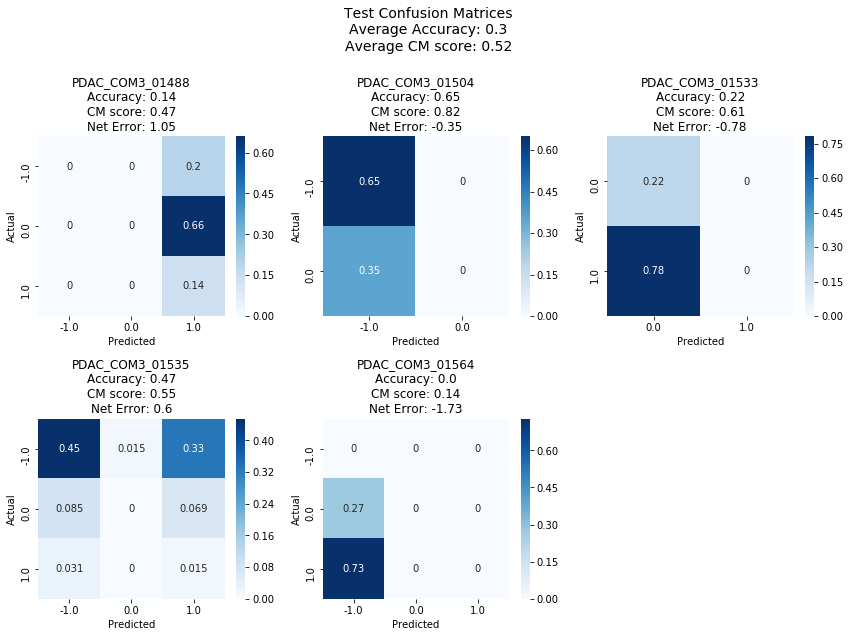

In [1457]:
stacker = LogisticRegression(C=0.00001)
#stacker = DecisionTreeClassifier(max_depth=10,max_features=None)
#stacker = AdaBoostClassifier(n_estimators=20,learning_rate=0.5)

sft1 = SingleFeatureDecisionTree(feature_index=0,splitter='best',max_depth=10)
sft2 = SingleFeatureDecisionTree(feature_index=1,splitter='best',max_depth=10)
sft3 = SingleFeatureDecisionTree(feature_index=2,splitter='best',max_depth=10)


# estimators = {}
# for i in range(X_min.shape[1]):
#     sf = SingleFeatureDecisionTree(feature_index=i,splitter='best',max_depth=10)
#     estimators[f'sft{i}'] = sf

estimators = {}
#estimators['sft'] = sft
estimators['rf'] = rf
estimators['svc'] = svc
#estimators['dtf'] = dtf

stacked_model_loco_cv(estimators,X,y_labels,clusters,stacker,base_train_loco=True,include_orig_features=True)

# Use predicted class in regression

In [1451]:
clf_stacker = LogisticRegression(C=0.00001)
rf = RandomForestClassifier(n_estimators=5, max_features=2, max_depth=1, min_samples_leaf=1, min_samples_split=2,
                            criterion='gini', bootstrap=False)
svc = SVC(C=1, kernel='poly', degree=5, gamma=0.5)
base_clf = {}
base_clf['rf'] = rf
base_clf['svc'] = svc

stacked_clf = StackedEstimator(base_clf,clf_stacker,include_orig_features=True,normalize=True)

lr_stacker = ElasticNet(alpha=0.001,l1_ratio=0.5)
base_reg = {'stacked_clf':stacked_clf}
stacked_lr = StackedEstimator(base_reg,lr_stacker,include_orig_features=True,normalize=True)

cv_cluster = 'PDAC_COM3_01564'
train_idx = np.where(clusters!=cv_cluster)
test_idx = np.where(clusters==cv_cluster)
X_train = X_min[train_idx]
y_train = y_labels[train_idx]
clusters_train = clusters[train_idx]

X_test = X_min[test_idx]
y_test = y_labels[test_idx]

stacked_lr.fit(X_train, y_train, clusters_train)
stacked_lr.score(X_test,y_test)

-7.294542011166319

In [1171]:
X_train_base[:,4]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1